# ML for currency prediction: USD/CHF 

## Preprocessing 

### Import & load data

In [42]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm 
import random 

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

df = pd.read_csv("Data/data_daily/dataset_daily.csv")
data = []
for i in df.columns[1:]:
    data.append(df[i])

df.head(4)

Date  Open_USD_CHF  Open_CHF_EUR  Open_CHF_GBP  Open_CHF_JPY  \
0  2001-12-28        1.6776        0.6745        0.4106         78.48   
1  2002-01-04        1.6506        0.6733        0.4210         79.79   
2  2002-01-07        1.6520        0.6760        0.4180         79.26   
3  2002-01-08        1.6480        0.6785        0.4209         79.49   

   Open_CHF_CAD  Open_USD_JPY  Open_USD_EUR  Open_USD_GBP  Open_USD_CAD  \
0        0.9520        131.68        1.1319        0.6887        1.5981   
1        0.9677        131.72        1.1126        0.6953        1.5984   
2        0.9657        130.90        1.1168        0.6906        1.5956   
3        0.9695        131.04        1.1187        0.6940        1.5987   

   Prev_Close_USD_CHF  Prev_Close_BondCH1m  Prev_Close_BondCH2y  \
0              1.6806                 1.68                2.011   
1              1.6500                 1.72                2.059   
2              1.6519                 1.69                1.966   
3              1.6490                 1.65                2.531   

   Prev_Close_BondCH10y  Prev_Close_SMI  Prev_Close_BondUS1m  \
0                 3.460          6410.6                1.751   
1                 3.403          6380.9                1.720   
2                 3.412          6392.9                1.725   
3                 3.401          6384.4                1.700   

   Prev_Close_BondUS2y  Prev_Close_BondUS10y  Prev_Close_SP500  
0                3.307                 5.072            1157.1  
1                3.168                 5.111            1165.3  
2                3.170                 5.125            1172.5  
3                3.053                 5.049            1164.9

### Data distribution 

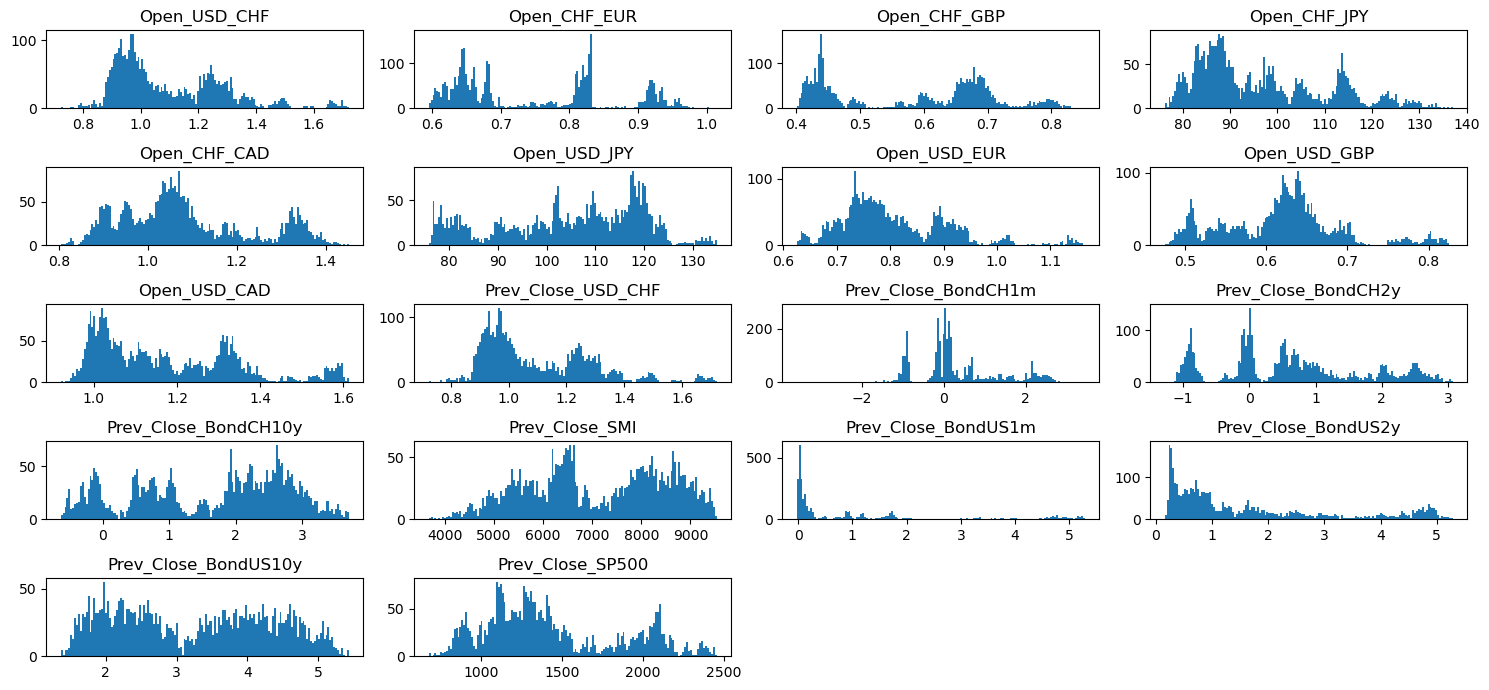

In [43]:
fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

### Generate Dataset 

In [44]:
result_price_df = pd.DataFrame(index=['MSE','ACC','MEAN RET %'])
result_trend_df = pd.DataFrame(index=['ACC','MEAN RET %'])

device = 'cpu'
LOOKBACK = 6
span_trend = 4
fraction_val = 0.125
fraction_test = 0.2    

# train_y, val_y, test_y WITH TREND LABEL: 0 or 1.
train_x, val_x, test_x, train_y, val_y, test_y, _, price_tuple= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=span_trend,
  span_back_trend_= 0,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

# rain_y_reg, val_y_reg, test_y_reg WITH PRICE LABEL: USD/CHF.
_, _, _, train_y_reg, val_y_reg, test_y_reg, norm, _= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=False,
  span_trend_=span_trend,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

Number nan: 33 (for var len = 2475)
Number nan: 29 (for var len = 354)
Number nan: 34 (for var len = 709)
Shape:             
X train     (2466, 6, 36), y train     (2466, 18)            
X train val (345, 6, 36) , y train val (345, 18)             
X test      (700, 6, 36) , y test      (700, 18)             
Price       3538
Number nan: 33 (for var len = 2475)
Number nan: 29 (for var len = 354)
Number nan: 34 (for var len = 709)
Shape:             
X train     (2466, 6, 36), y train     (2466, 18)            
X train val (345, 6, 36) , y train val (345, 18)             
X test      (700, 6, 36) , y test      (700, 18)             
Price       3538


In [45]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y_reg[np.isnan(train_y_reg)] = 0.5 
val_y_reg[np.isnan(val_y_reg)] = 0.5
test_y_reg[np.isnan(test_y_reg)] = 0.5

train_y_reg[np.isnan(train_y_reg)] , val_y_reg[np.isnan(val_y_reg)], test_y_reg[np.isnan(test_y_reg)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [46]:
buff = train_y[:,0]
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)
print(positive_weight)

tensor(1.1556)


### Inspect feature 

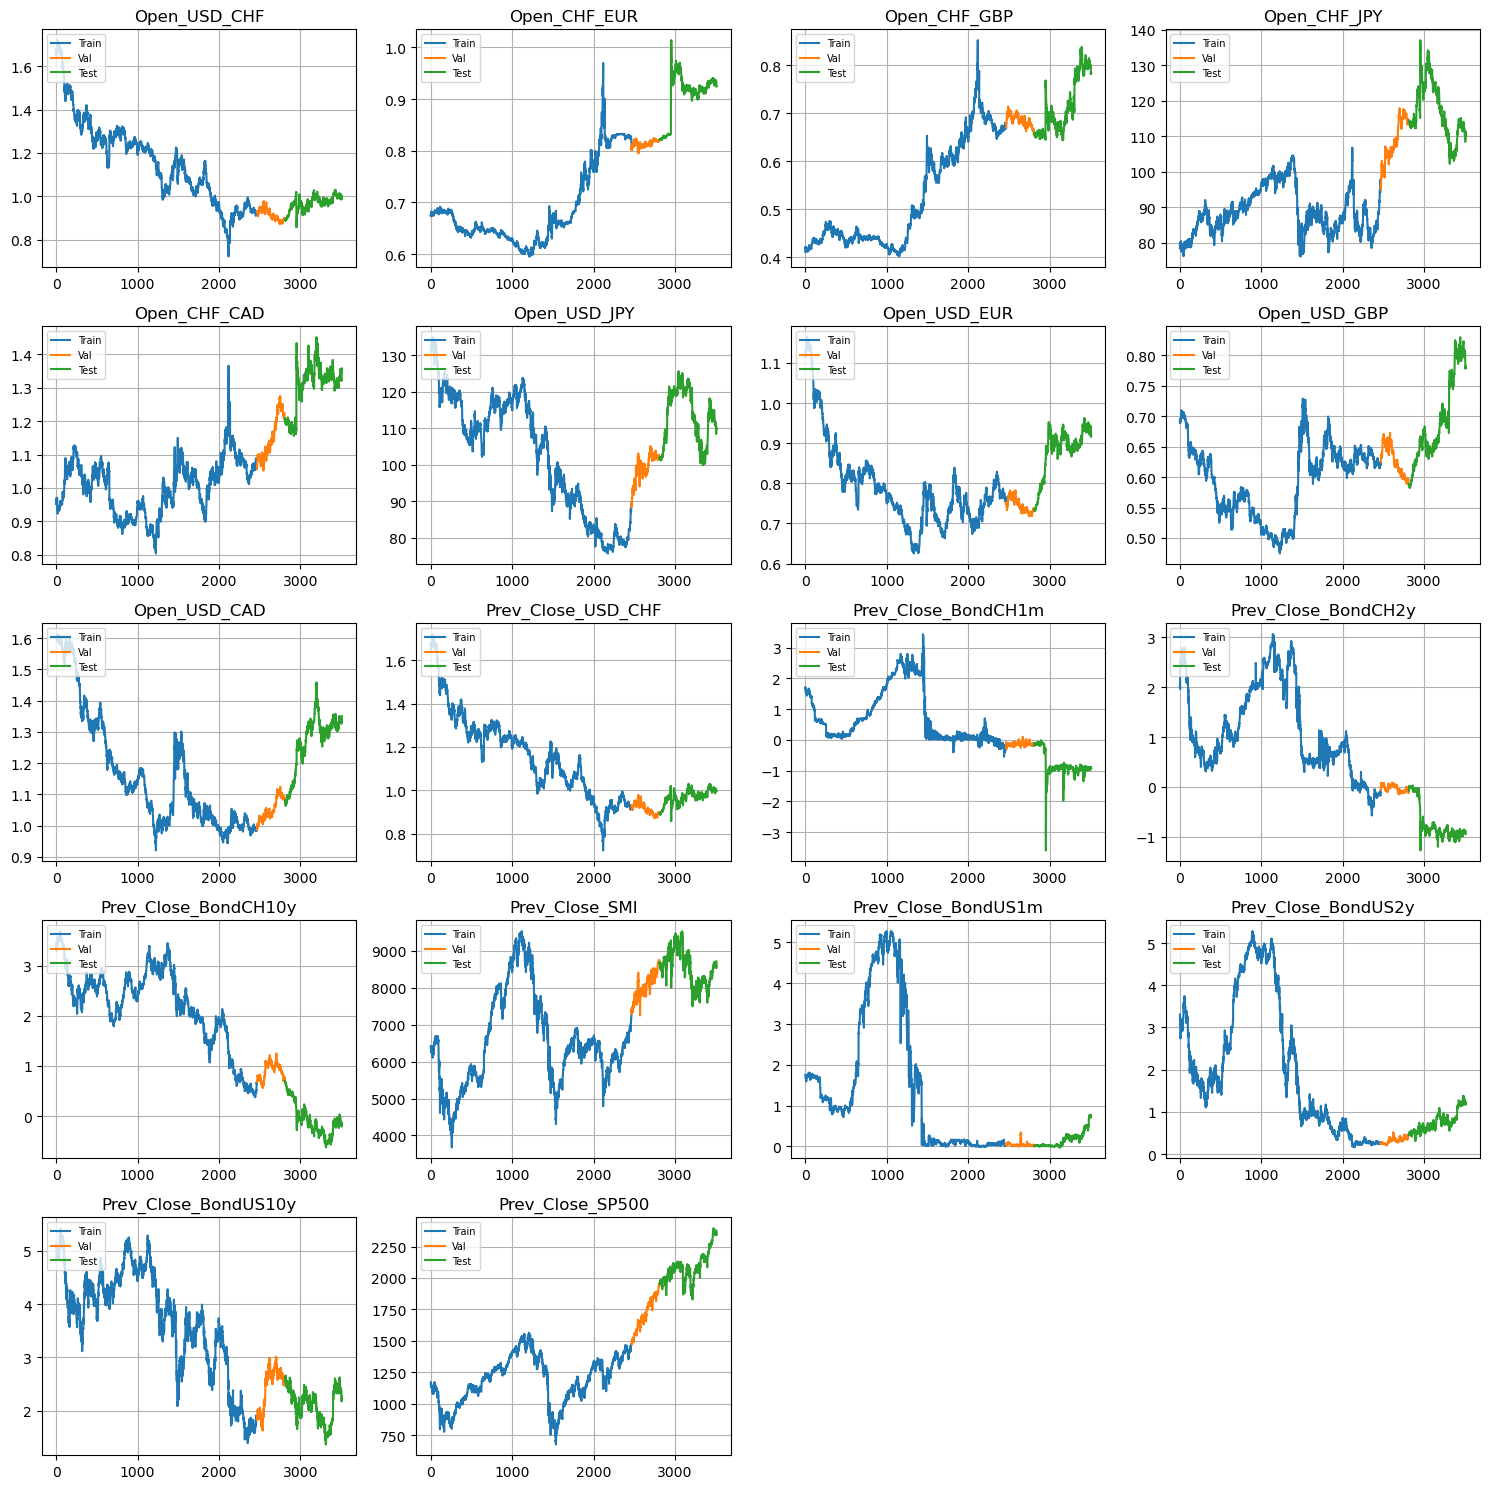

In [47]:
L1 = len(train_x)
L2 = len(val_x) + L1
L3 = len(test_x) + L2 

fig = plt.figure(figsize=(15, 15))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(L1), data[i].iloc[:L1], label='Train')
  plt.plot(np.arange(L1, L2), data[i].iloc[L1:L2], label='Val')
  plt.plot(np.arange(L2,L3), data[i].iloc[L2:L3], label='Test')
  plt.grid()
  plt.legend(loc='upper left', fontsize=7)

plt.tight_layout()
plt.show()

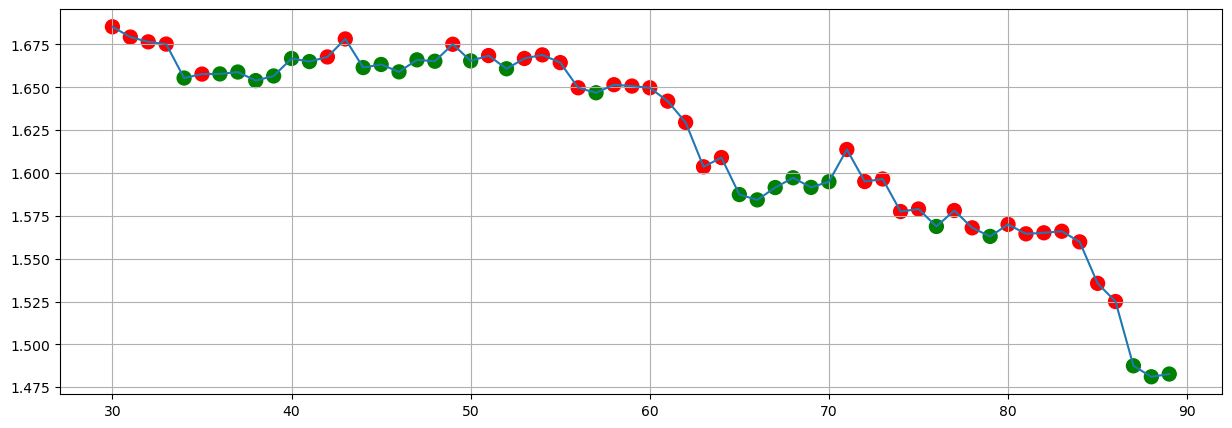

In [48]:
# TRAIN DATA
end = 90
start = 30

colors = {0:'red', 1:'green'}
plt.figure(figsize=(15,5))
scatter = plt.scatter(np.arange(start, end), price_tuple[0][start:end ], c=pd.Series(train_y[start:end,0]).map(colors).values, s=100)
plt.plot(np.arange(start, end), price_tuple[0][start: end ])

plt.grid()
plt.show()

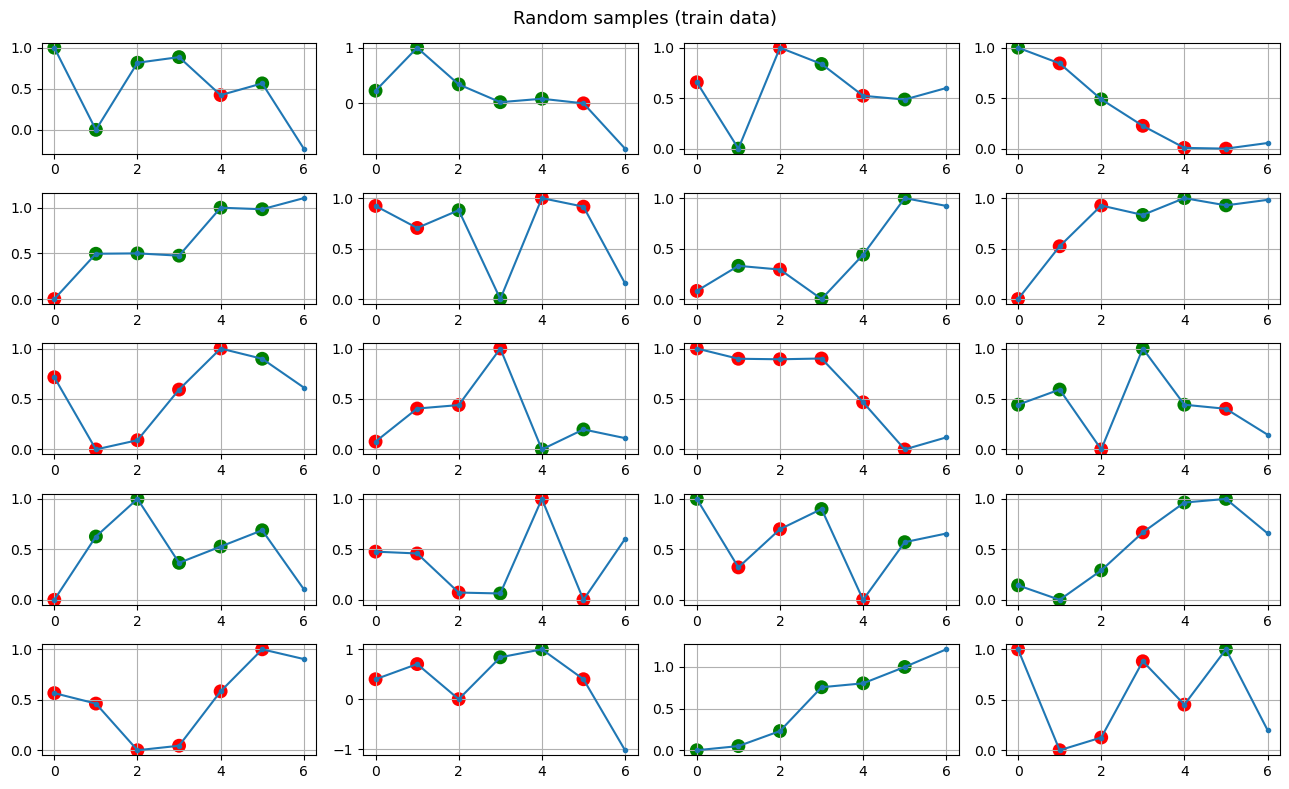

In [49]:
plt.figure(figsize=(13,8))
plt.suptitle("Random samples (train data)", fontsize=13)
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, train_x.shape[0]-1)
        colors = {0:'red', 1:'green'}
        all_series= np.concatenate((train_x[idx,:,0].reshape(-1,),train_y_reg[idx,0].reshape(-1,)))
        plt.scatter(np.arange(0,train_x.shape[1]), all_series[:-1], c=pd.Series( train_x[idx, :, 1]).map(colors).values, s=100, lw=0)
        ax.plot(all_series, '.-')
        ax.grid()
plt.tight_layout()
plt.show()

###

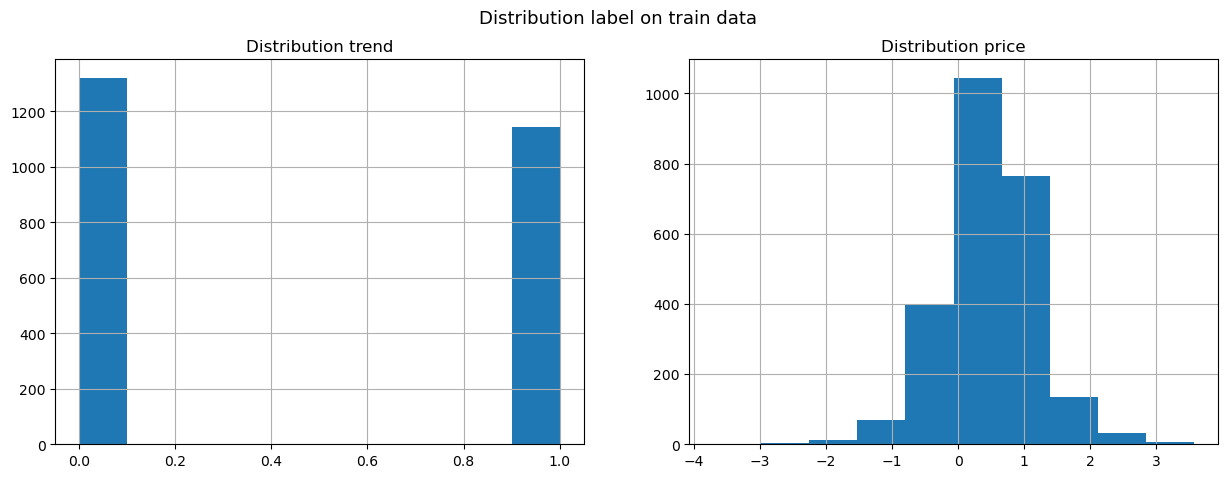

In [50]:
plt.figure(figsize=(15,5))
plt.suptitle("Distribution label on train data", fontsize=13)
plt.subplot(1,2,1)
plt.hist(train_y[:,0], )
plt.title("Distribution trend")
plt.grid()
plt.subplot(1,2,2)
plt.hist(train_y_reg[:,0], )
plt.title("Distribution price")
plt.grid()
plt.show()

## Model

### Auto-Encoder

#### Auto-Encoder Model

In [504]:
model_AutoEncoder = ml.Auto_Encoder(
    input_size = train_x.shape[2],
    nb_channel_conv = 12)
model_AutoEncoder.to(device)
model_AutoEncoder

Auto_Encoder(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv1d(36, 12, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(12, 36, kernel_size=(3,), stride=(1,))
)

 18%|█▊        | 890/5000 [04:31<20:54,  3.27it/s]

0.11924318343400955 < 0.11924328655004501
Epoch: 891/5000
MSE = [train loss mean :  0.11733190] , [val loss mean:  0.12228987, MSE (last) 11.92450%]


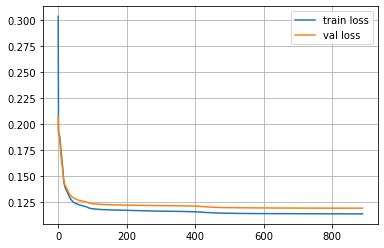

In [484]:
lr= 0.001
num_epochs= 5000

train_loss, val_loss = pl.train(
    model=model_AutoEncoder,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1 #int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938% 0.14284399


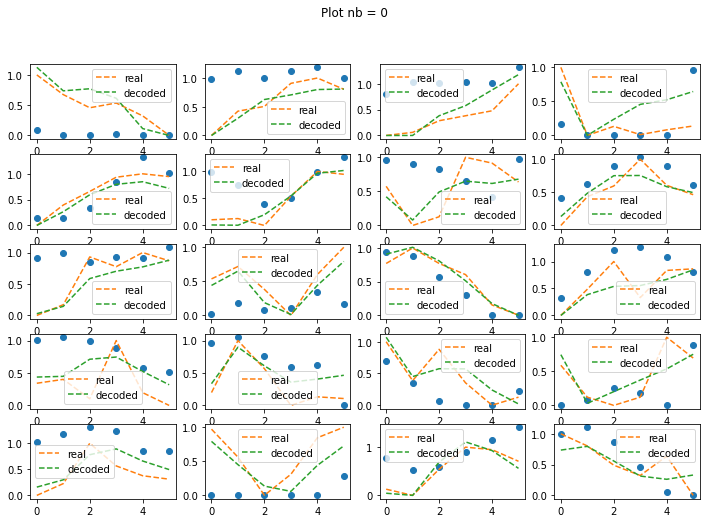

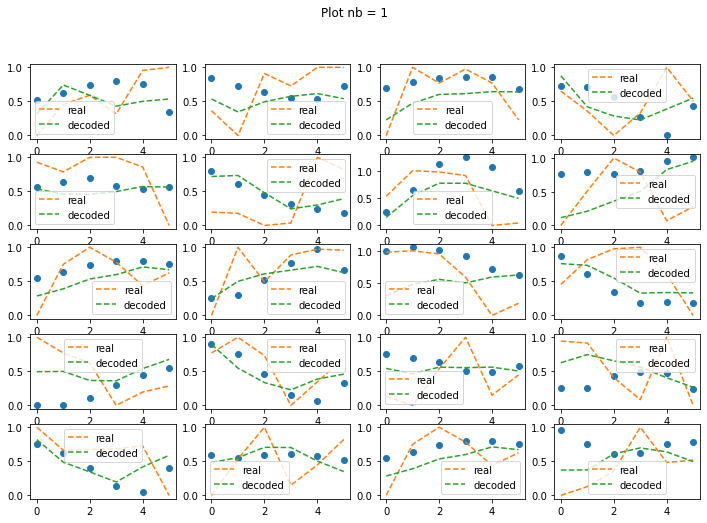

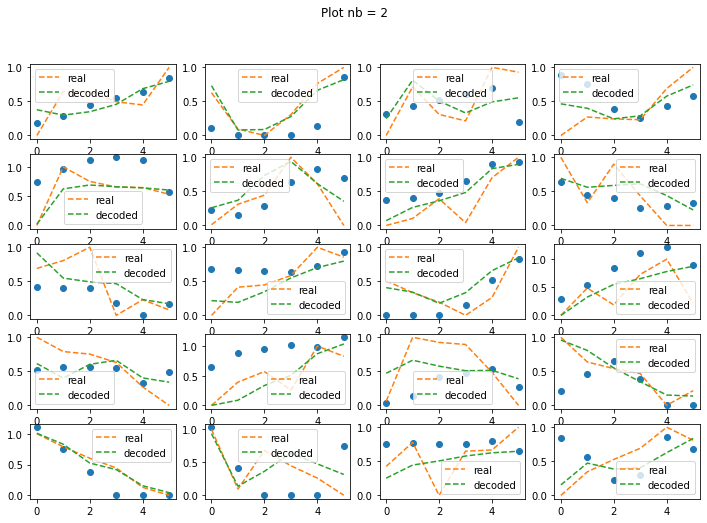

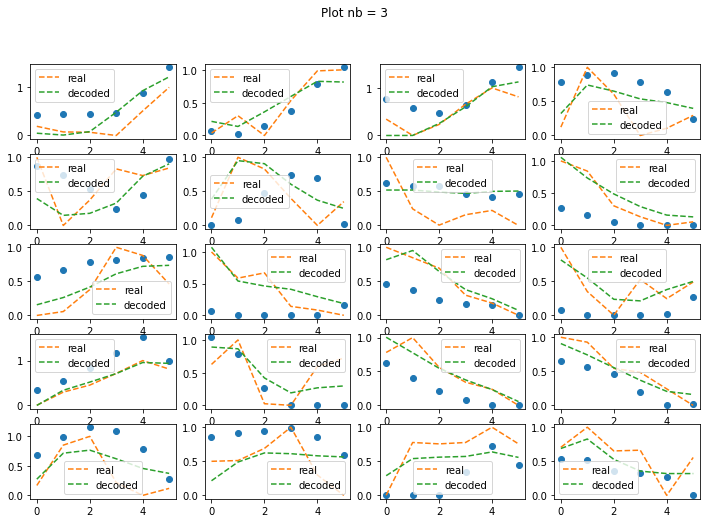

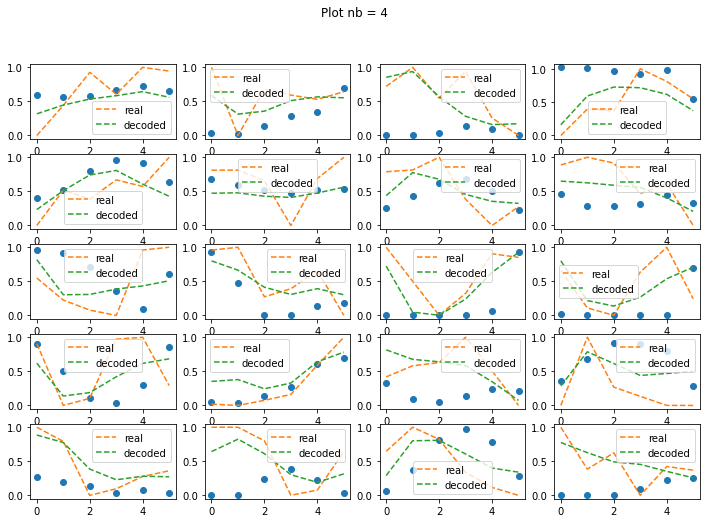

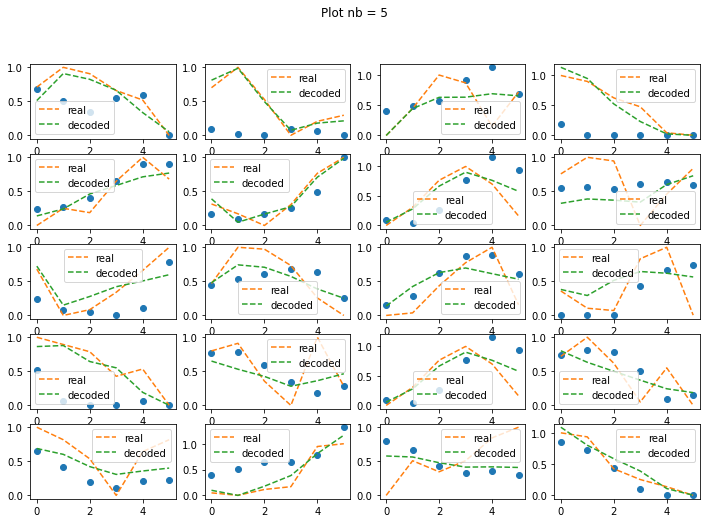

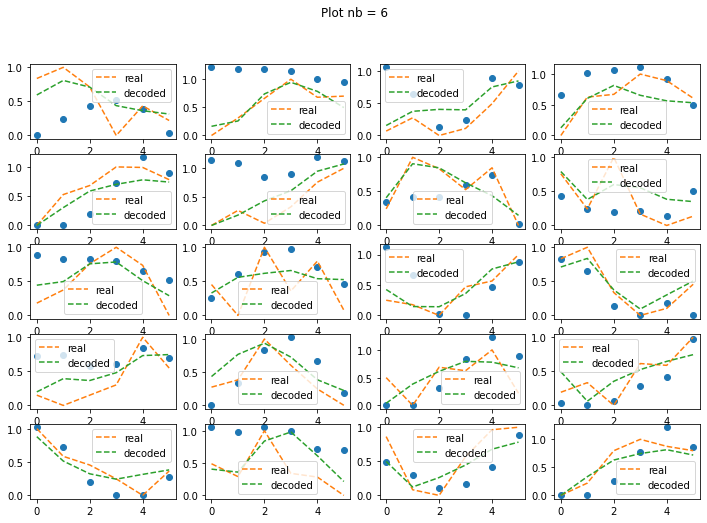

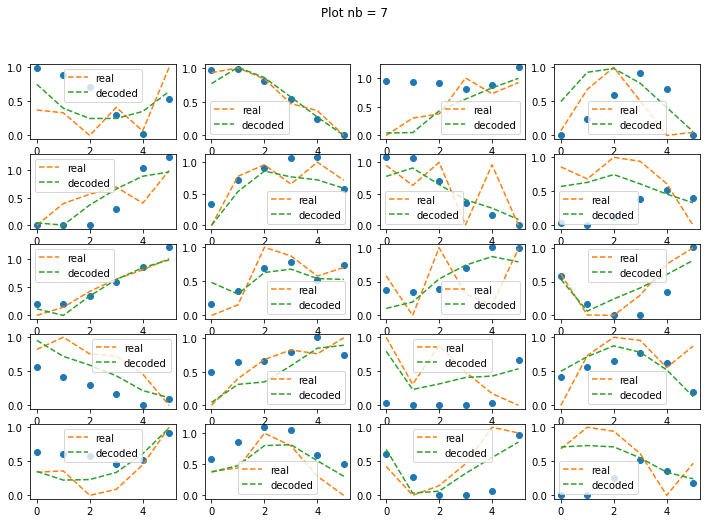

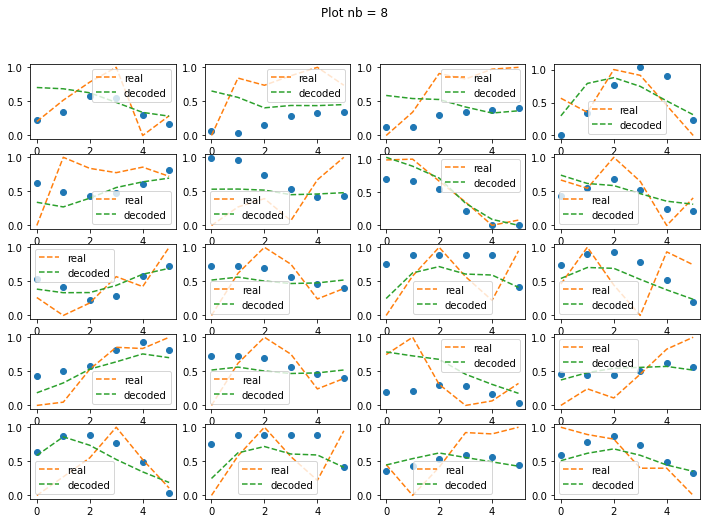

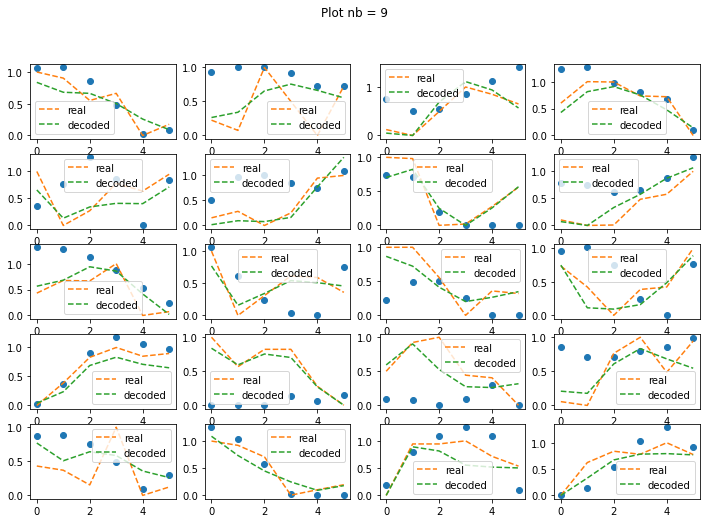

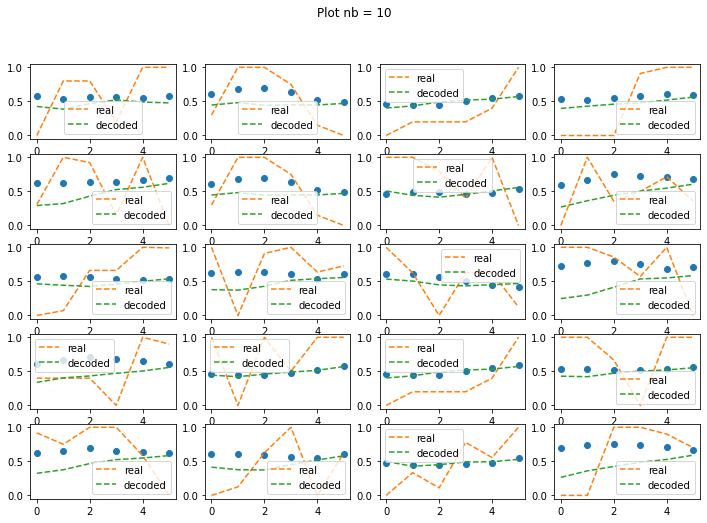

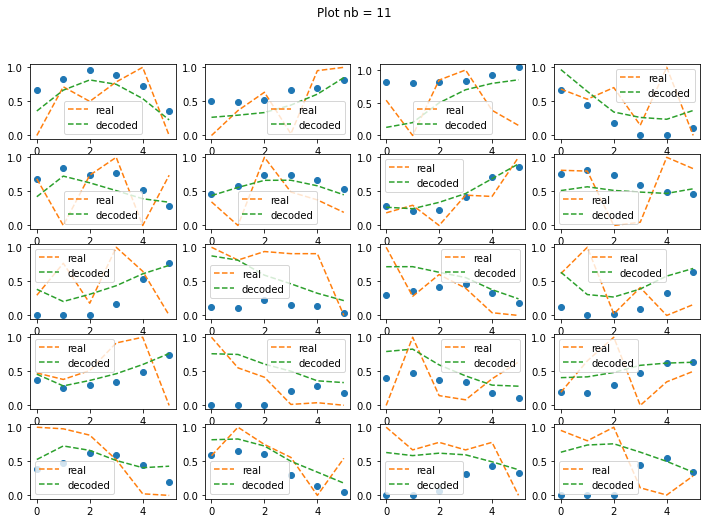

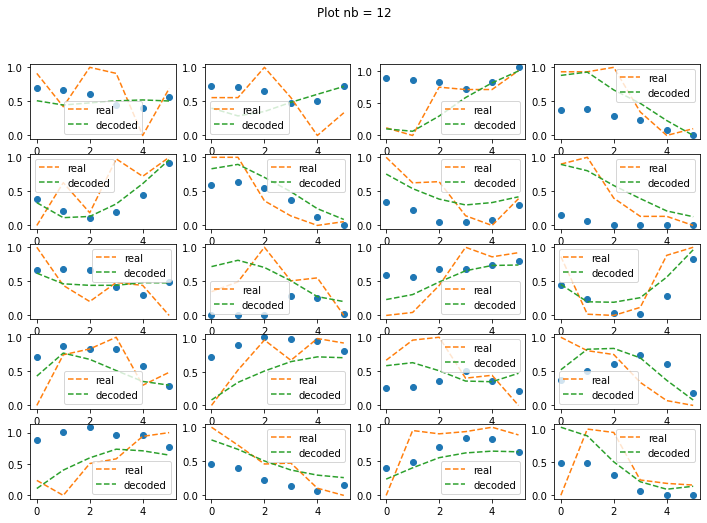

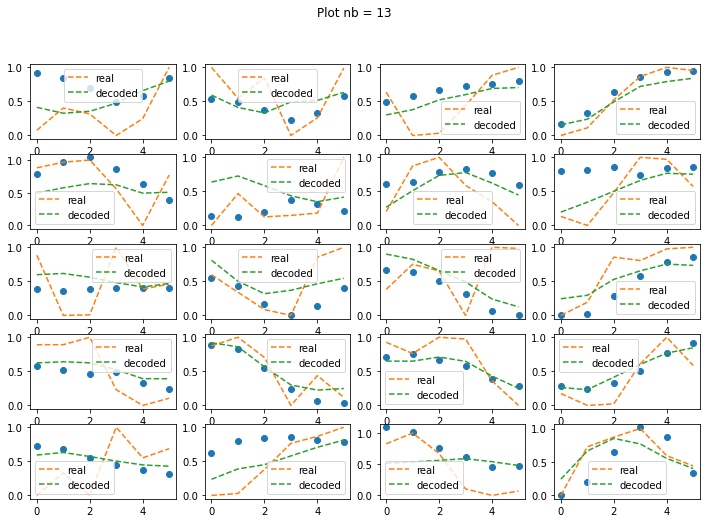

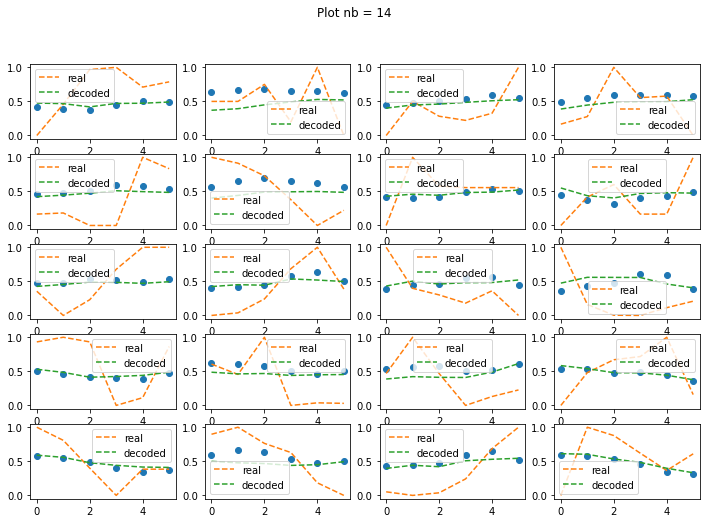

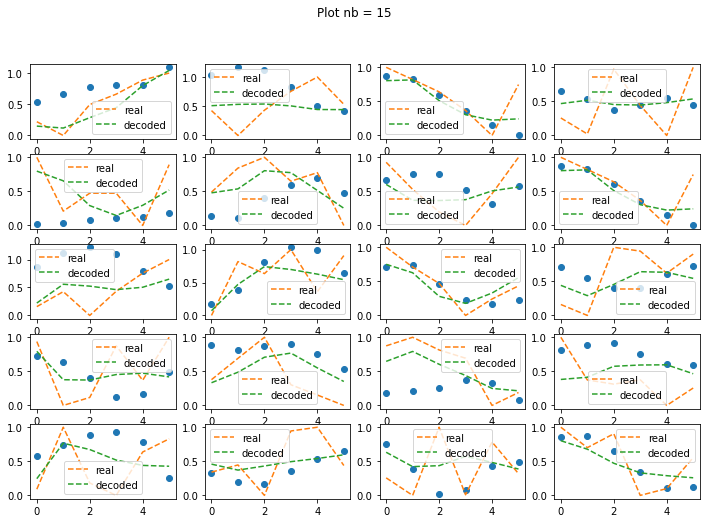

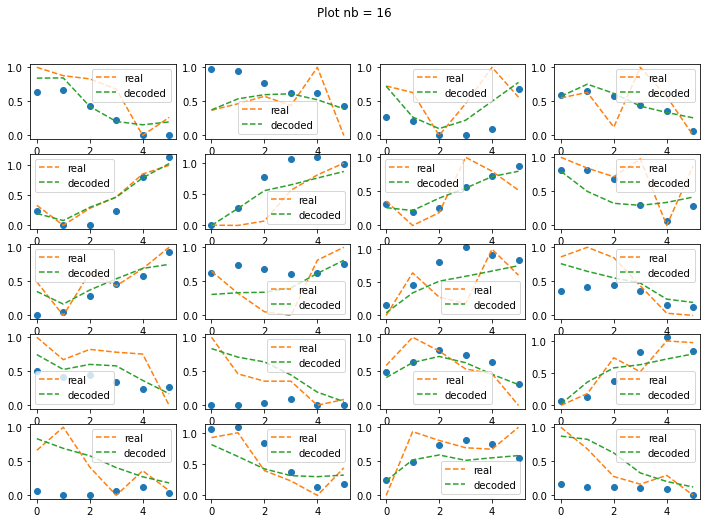

In [485]:
outputs_autoenc, targets, MSE = pl.evaluate(model_AutoEncoder, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 

for p in range(17):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0]-1)
           
            ax.plot(outputs_autoenc[idx,p*2+1,:], 'o')
            ax.plot(test_x[idx,:,p*2], '--', label= "real")
            ax.plot(outputs_autoenc[idx,p*2,:], '--', label= "decoded")

            ax.legend()
    plt.show() 

In [505]:
torch.save(model_AutoEncoder.cpu().state_dict(), 'Helper/model/model_AutoEncoder.pth')


#### Apply Auto-Encoder to the dataset 

In [51]:
model_AutoEncoder = ml.Auto_Encoder(
    input_size = train_x.shape[2],
    nb_channel_conv = 12)
model_AutoEncoder.load_state_dict(torch.load('Helper/model/model_AutoEncoder.pth'))
model_AutoEncoder.to(device)
model_AutoEncoder

Auto_Encoder(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv1d(36, 12, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(12, 36, kernel_size=(3,), stride=(1,))
)

In [52]:
model_AutoEncoder.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_AutoEncoder(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_AutoEncoder(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out = model_AutoEncoder(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

### Determine if we use the original dataset or the augmented one

In [53]:
# UNCOMMENT TO USE ORIGINAL DATASET
# train_x = train_x[:,:,::2]
# test_x = test_x[:,:,::2]
# val_x = val_x[:,:,::2]

### Price prediction

#### Baseline

##### Dense

In [54]:
model_Dense = ml.Dense(
    num_layers = 2,
    layer_size = 32,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.05)
model_Dense.to(device)
model_Dense

Dense(
  (net): Sequential(
    (0): Linear(in_features=216, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

  6%|▋         | 65/1000 [00:06<01:39,  9.41it/s]


0.4262126642465591 < 0.4270531392097473
Epoch: 66/1000
MSE = [train loss mean :  0.32255020] , [val loss mean:  0.48943546, MSE (last) 43.77167%]


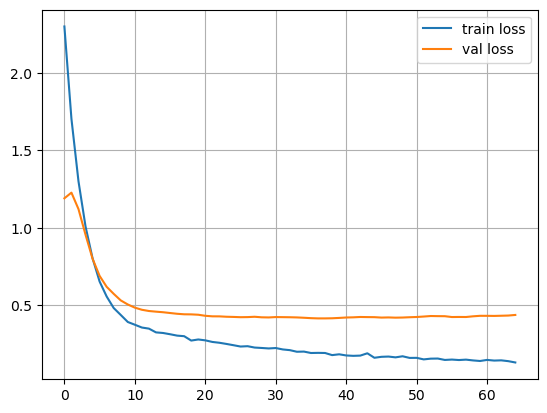

In [55]:
lr= 0.001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize = 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 


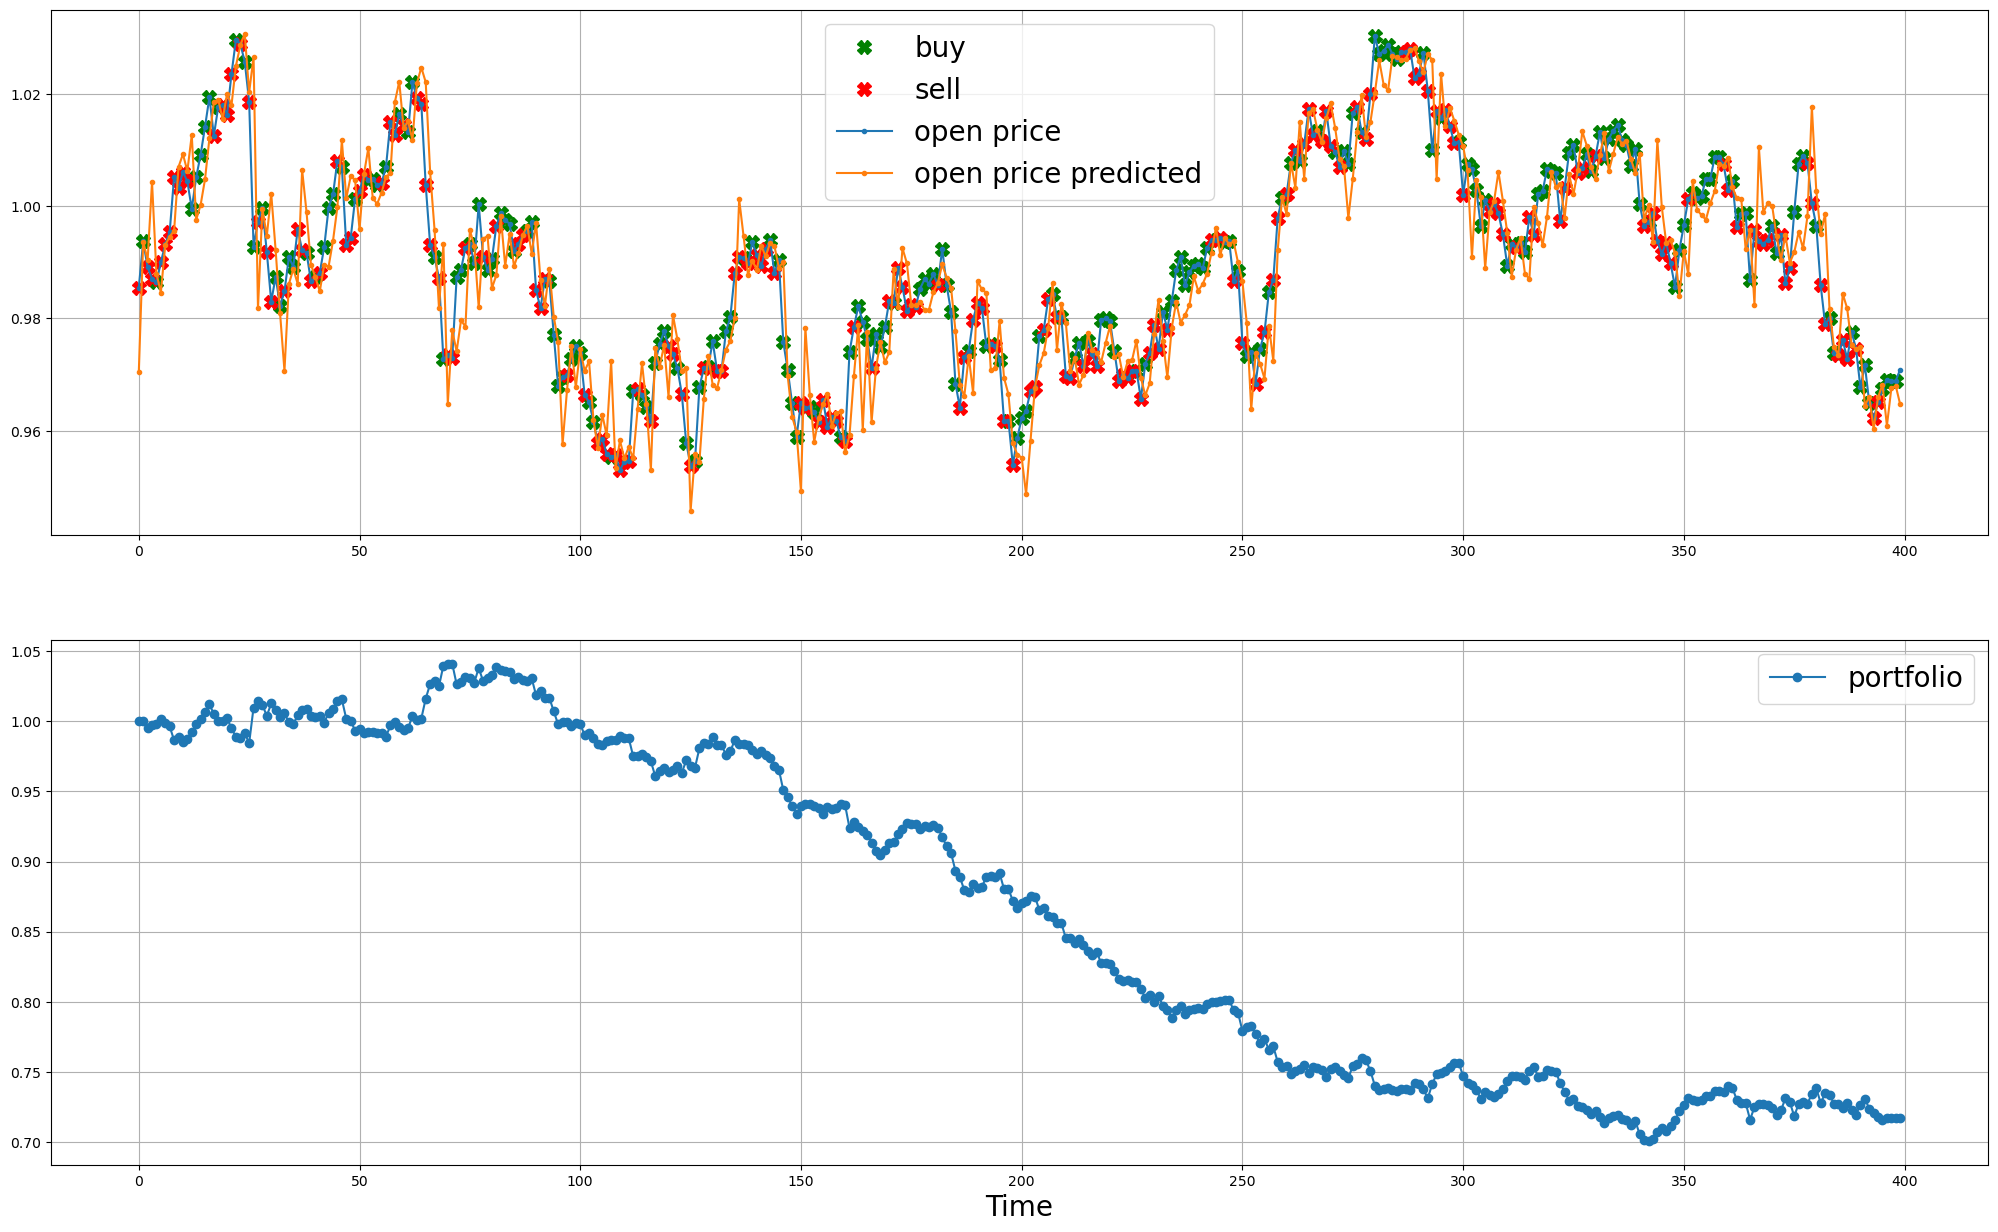

gain = -28.28%


MSE           0.000151
ACC           0.529328
MEAN RET %   -0.081597
Name: Dense, dtype: float64

In [56]:
outputs_Dense, targets, MSE = pl.evaluate(model_Dense, test_x.reshape(test_x.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense = pp.min_max_norm_inverse(outputs_Dense.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense = np.mean((outputs_Dense-t)**2)
ACC_Dense = pl.direction_accuracy(outputs_Dense, t)
MEAN_RET_Dense = pl.evauate_strategy(t, outputs_Dense, plot=True, tax=1)

result_price_df['Dense'] = [MSE_Dense, ACC_Dense, MEAN_RET_Dense]
result_price_df['Dense']

##### LSTM

In [57]:
model_LSTM = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM.to(device)
model_LSTM

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 200/1000 [01:08<04:54,  2.71it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.61170222] , [val loss mean:  0.59615921, MSE (last) 35.18246%]


 40%|███▉      | 399/1000 [02:11<03:17,  3.04it/s]

0.32552608907222746 < 0.3255751407146454
Epoch: 400/1000
MSE = [train loss mean :  0.30728688] , [val loss mean:  0.33386630, MSE (last) 32.56198%]


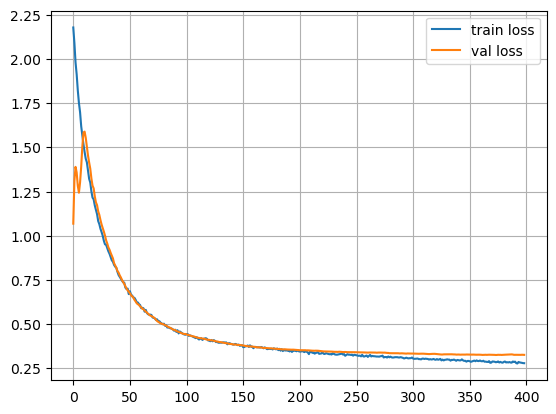

In [58]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 


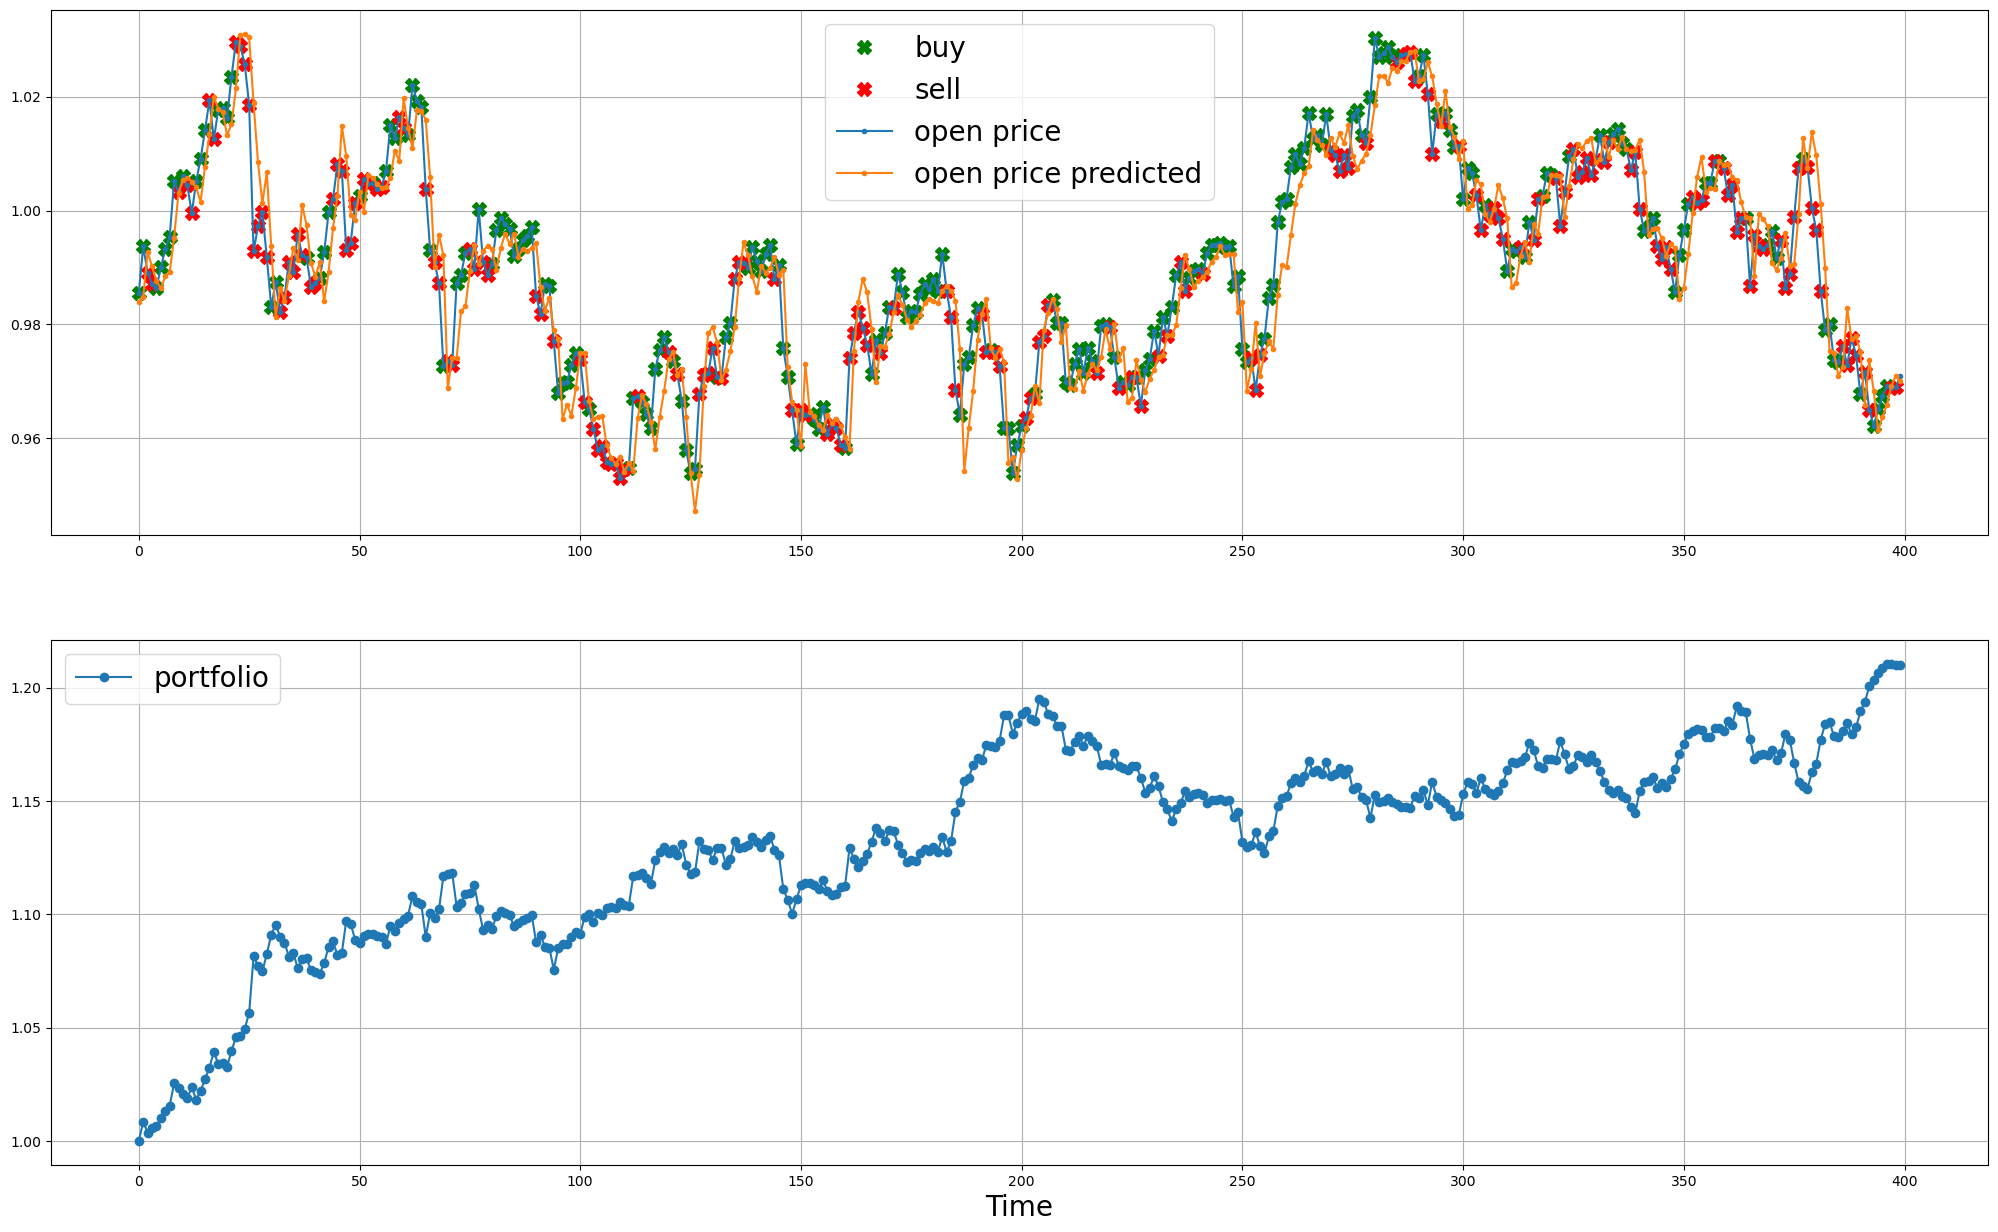

gain = 21.02%


MSE           0.000099
ACC           0.502146
MEAN RET %    0.048840
Name: LSTM, dtype: float64

In [59]:
outputs_LSTM, targets, MSE = pl.evaluate(model_LSTM, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM = pp.min_max_norm_inverse(outputs_LSTM.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM = np.mean((outputs_LSTM-t)**2)
ACC_LSTM = pl.direction_accuracy(outputs_LSTM, t)
MEAN_RET_LSTM = pl.evauate_strategy(t, outputs_LSTM, plot=True, tax=1)

result_price_df['LSTM'] = [MSE_LSTM, ACC_LSTM, MEAN_RET_LSTM]
result_price_df['LSTM']

##### GRU 

In [64]:
model_GRU = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU.to(device)
model_GRU

GRU_base(
  (gru): GRU(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 200/1000 [01:09<05:05,  2.62it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.42742033] , [val loss mean:  0.39952295, MSE (last) 34.21003%]


 34%|███▎      | 337/1000 [01:57<03:51,  2.87it/s]

0.3320033520460129 < 0.3320456874370575
Epoch: 338/1000
MSE = [train loss mean :  0.32970823] , [val loss mean:  0.33880253, MSE (last) 33.30361%]


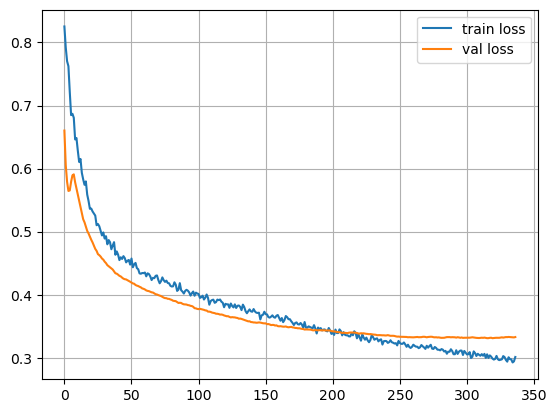

In [65]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

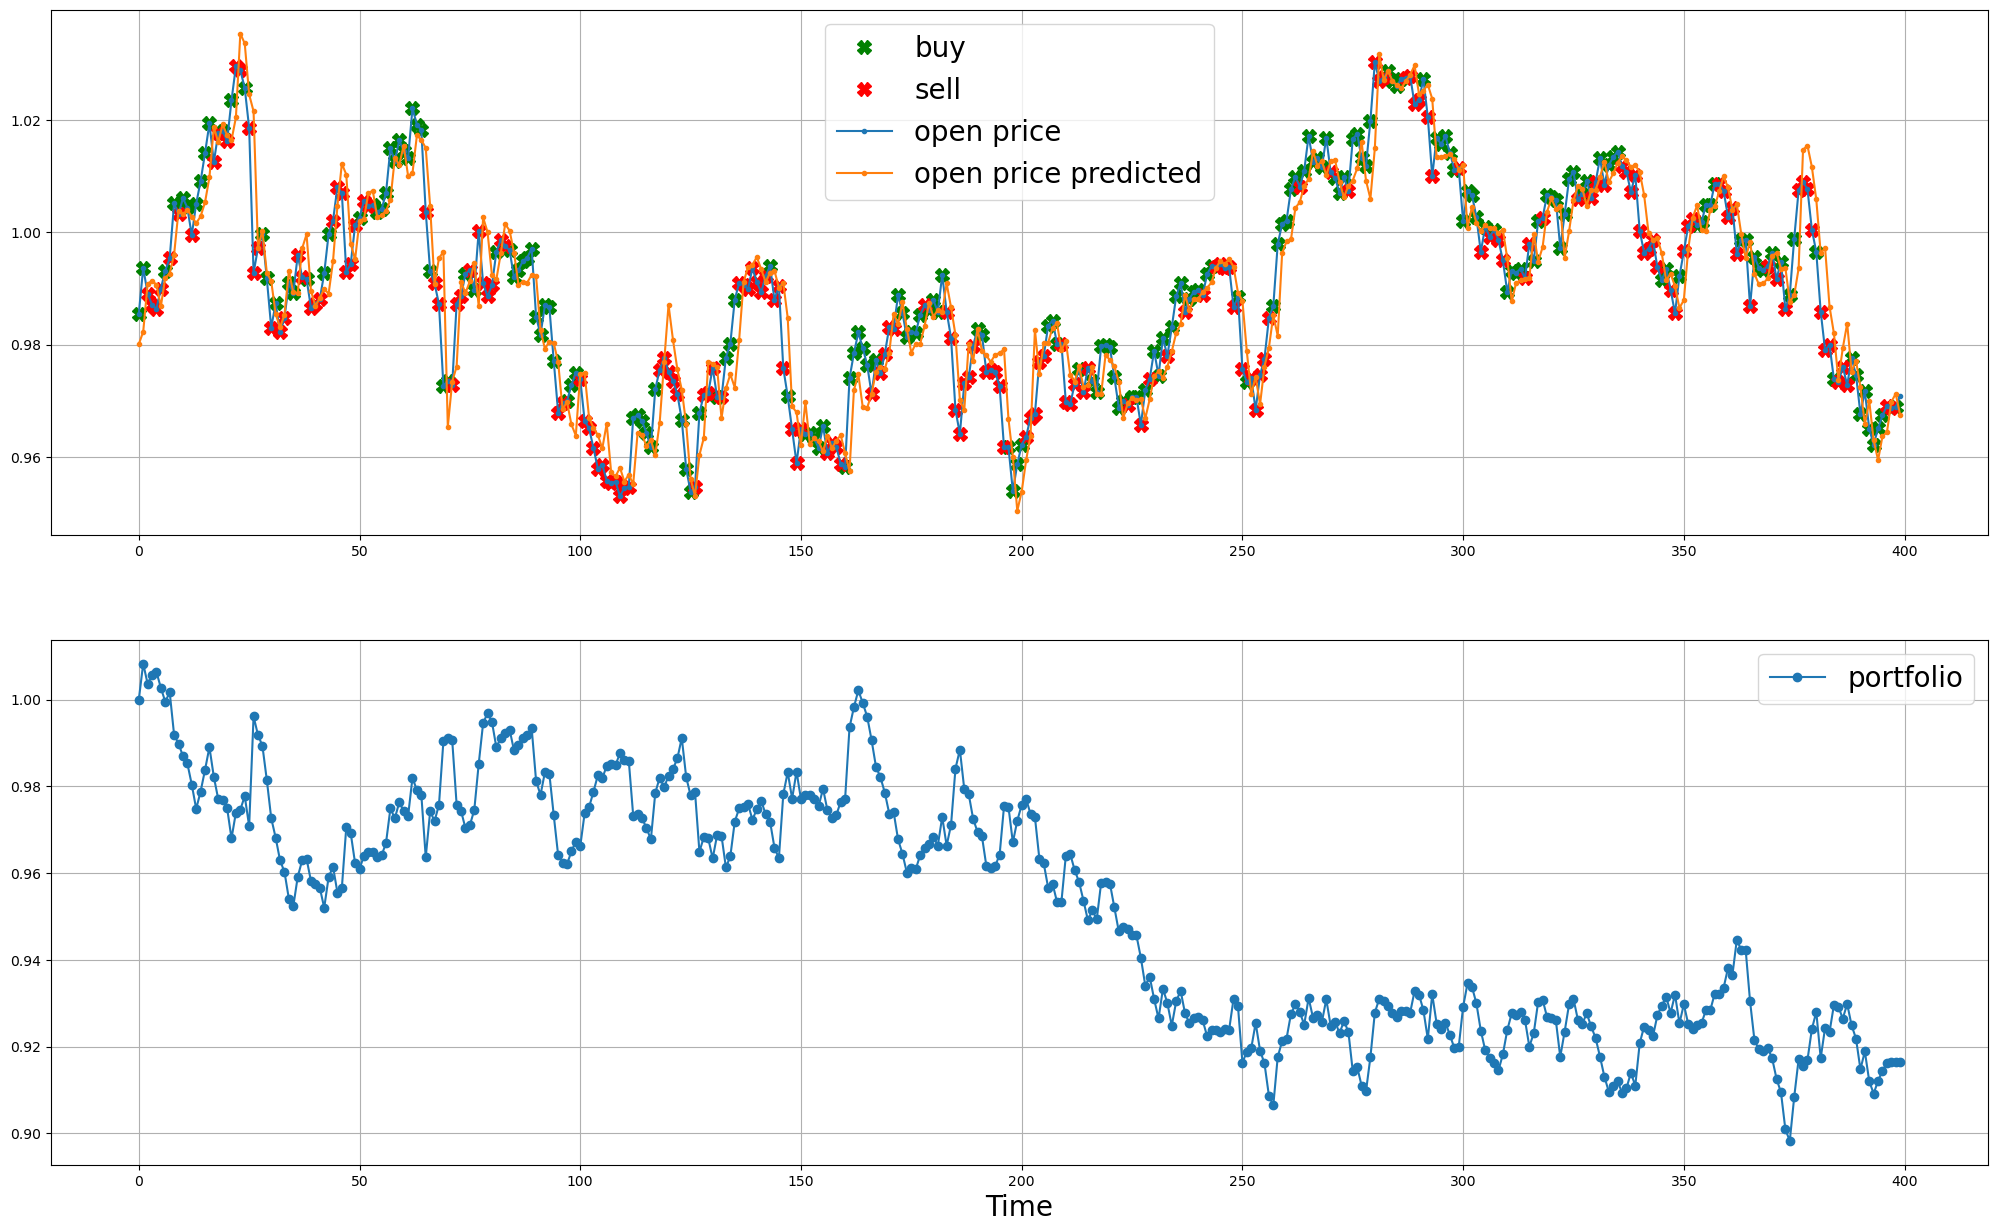

gain = -8.36%


MSE           0.000084
ACC           0.525036
MEAN RET %   -0.020455
Name: GRU, dtype: float64

In [66]:
outputs_GRU, targets, MSE = pl.evaluate(model_GRU, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU = pp.min_max_norm_inverse(outputs_GRU.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU = np.mean((outputs_GRU-t)**2)
ACC_GRU = pl.direction_accuracy(outputs_GRU, t)
MEAN_RET_GRU = pl.evauate_strategy(t, outputs_GRU, plot=True, tax=1)

result_price_df['GRU'] = [MSE_GRU, ACC_GRU, MEAN_RET_GRU]
result_price_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [105]:
model_Dense_AE = ml.Dense(
    num_layers = 2,
    layer_size = 32,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.05)
model_Dense_AE.to(device)
model_Dense_AE

Dense(
  (net): Sequential(
    (0): Linear(in_features=216, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

 10%|█         | 102/1000 [00:10<01:28, 10.18it/s]


0.5159822052717209 < 0.5184839177131653
Epoch: 103/1000
MSE = [train loss mean :  0.55314525] , [val loss mean:  0.58895419, MSE (last) 71.44883%]


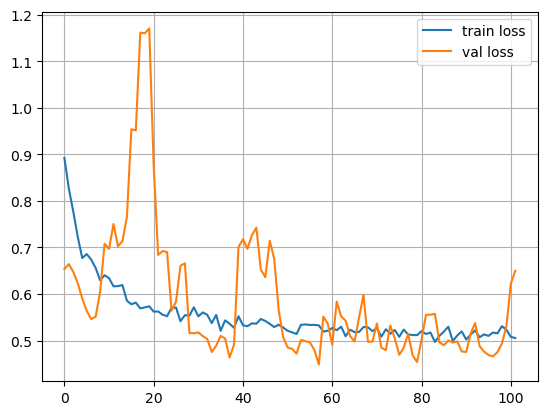

In [106]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

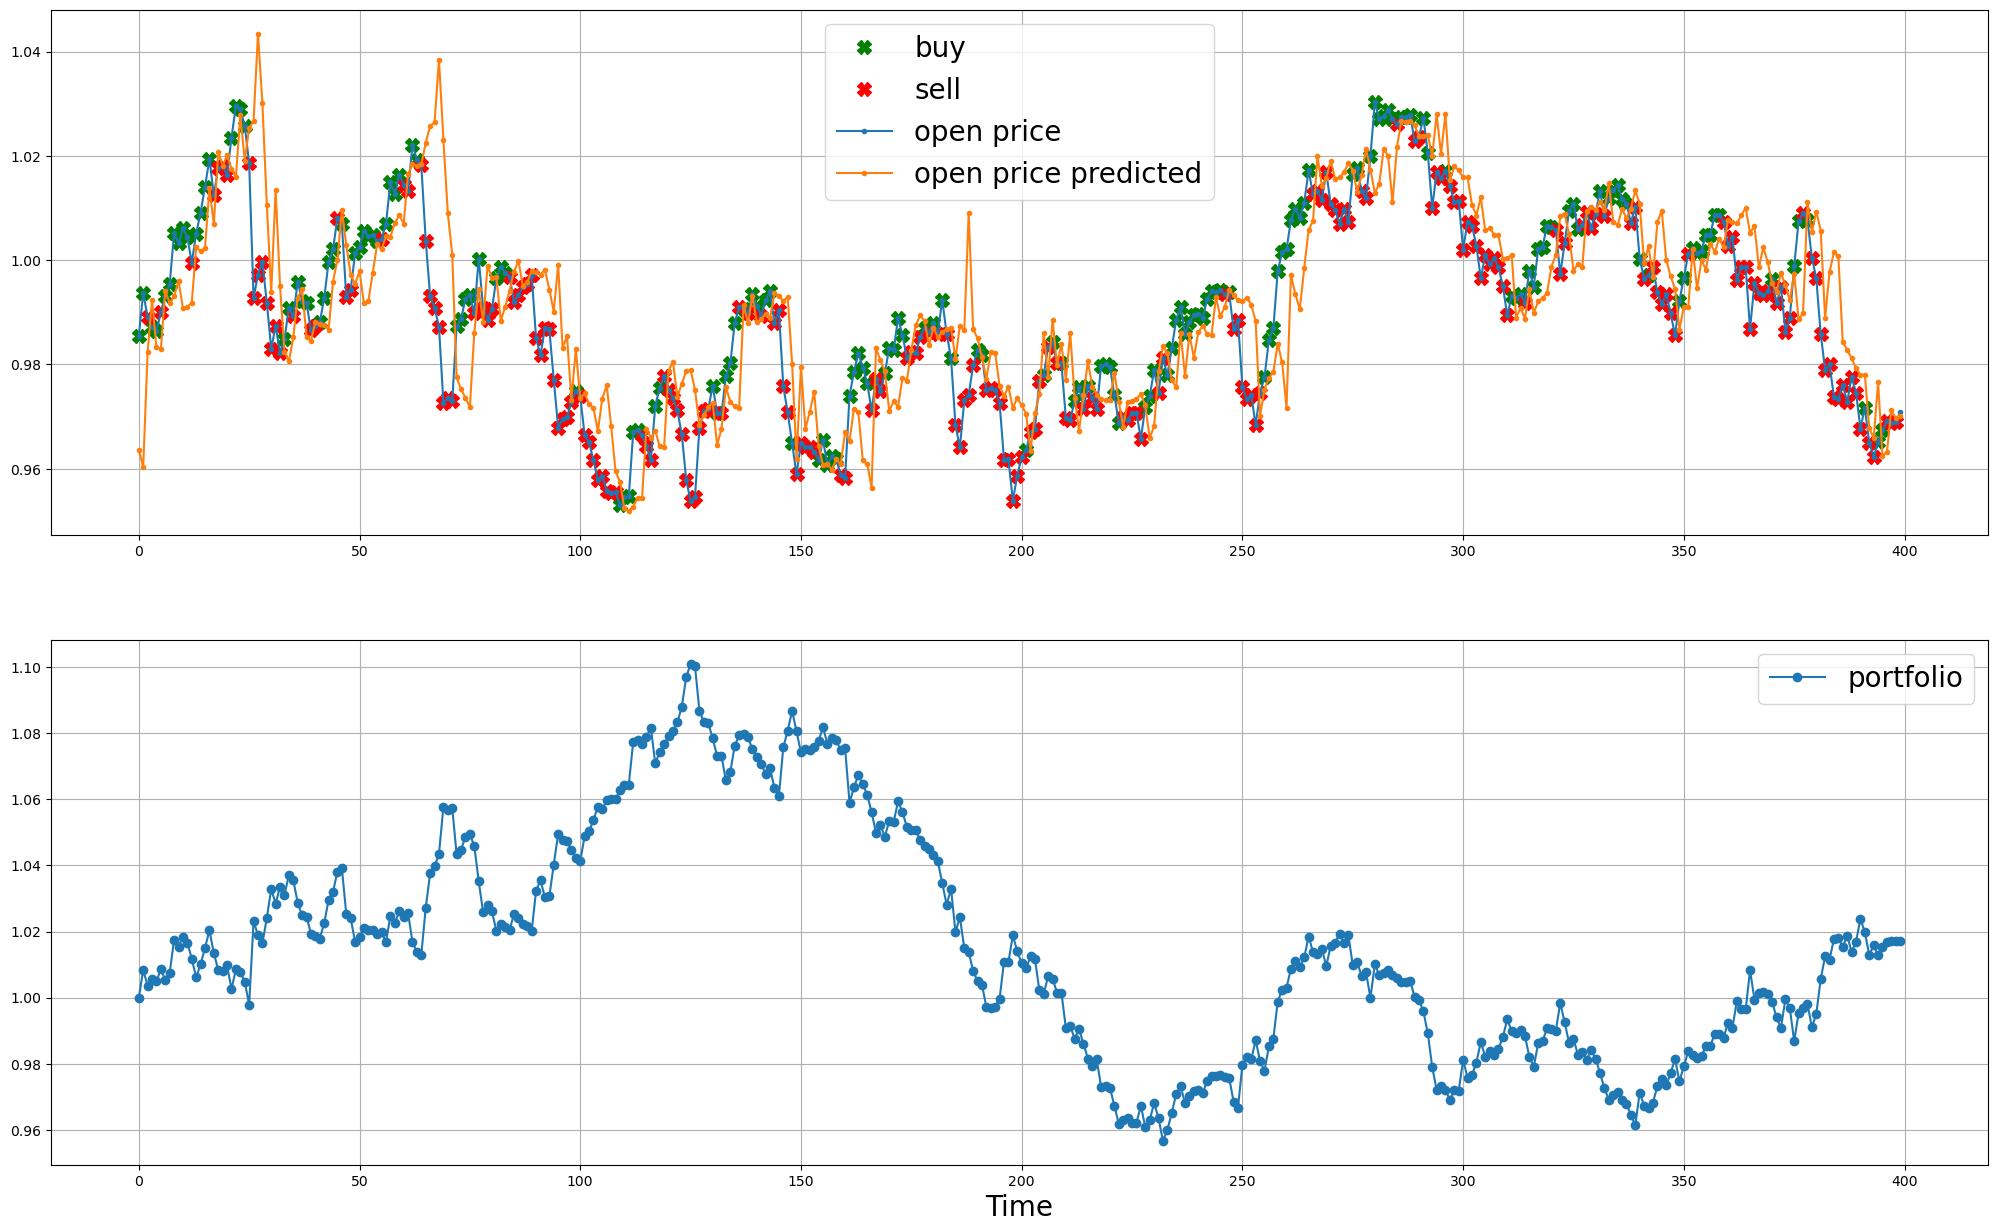

gain = 1.71%


MSE           0.000244
ACC           0.525036
MEAN RET %    0.005501
Name: Dense_AE, dtype: float64

In [107]:
outputs_Dense_AE, targets, MSE = pl.evaluate(model_Dense_AE, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE = pp.min_max_norm_inverse(outputs_Dense_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE = np.mean((outputs_Dense_AE-t)**2)
ACC_Dense_AE = pl.direction_accuracy(outputs_Dense_AE, t)
MEAN_RET_Dense_AE = pl.evauate_strategy(t, outputs_Dense_AE, plot=True, tax=1)

result_price_df['Dense_AE'] = [MSE_Dense_AE, ACC_Dense_AE, MEAN_RET_Dense_AE]
result_price_df['Dense_AE']

##### LSTM + AE

In [70]:
model_LSTM_AE = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE.to(device)
model_LSTM_AE

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  7%|▋         | 73/1000 [00:29<06:09,  2.51it/s]

0.8575331366062164 < 0.8595153665542603
Epoch: 74/1000
MSE = [train loss mean :  1.07316055] , [val loss mean:  0.93164481, MSE (last) 86.03637%]


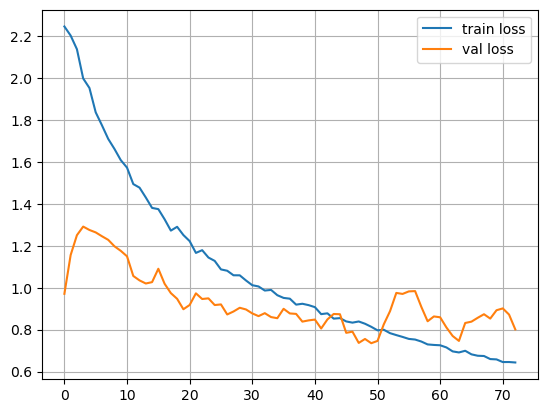

In [71]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

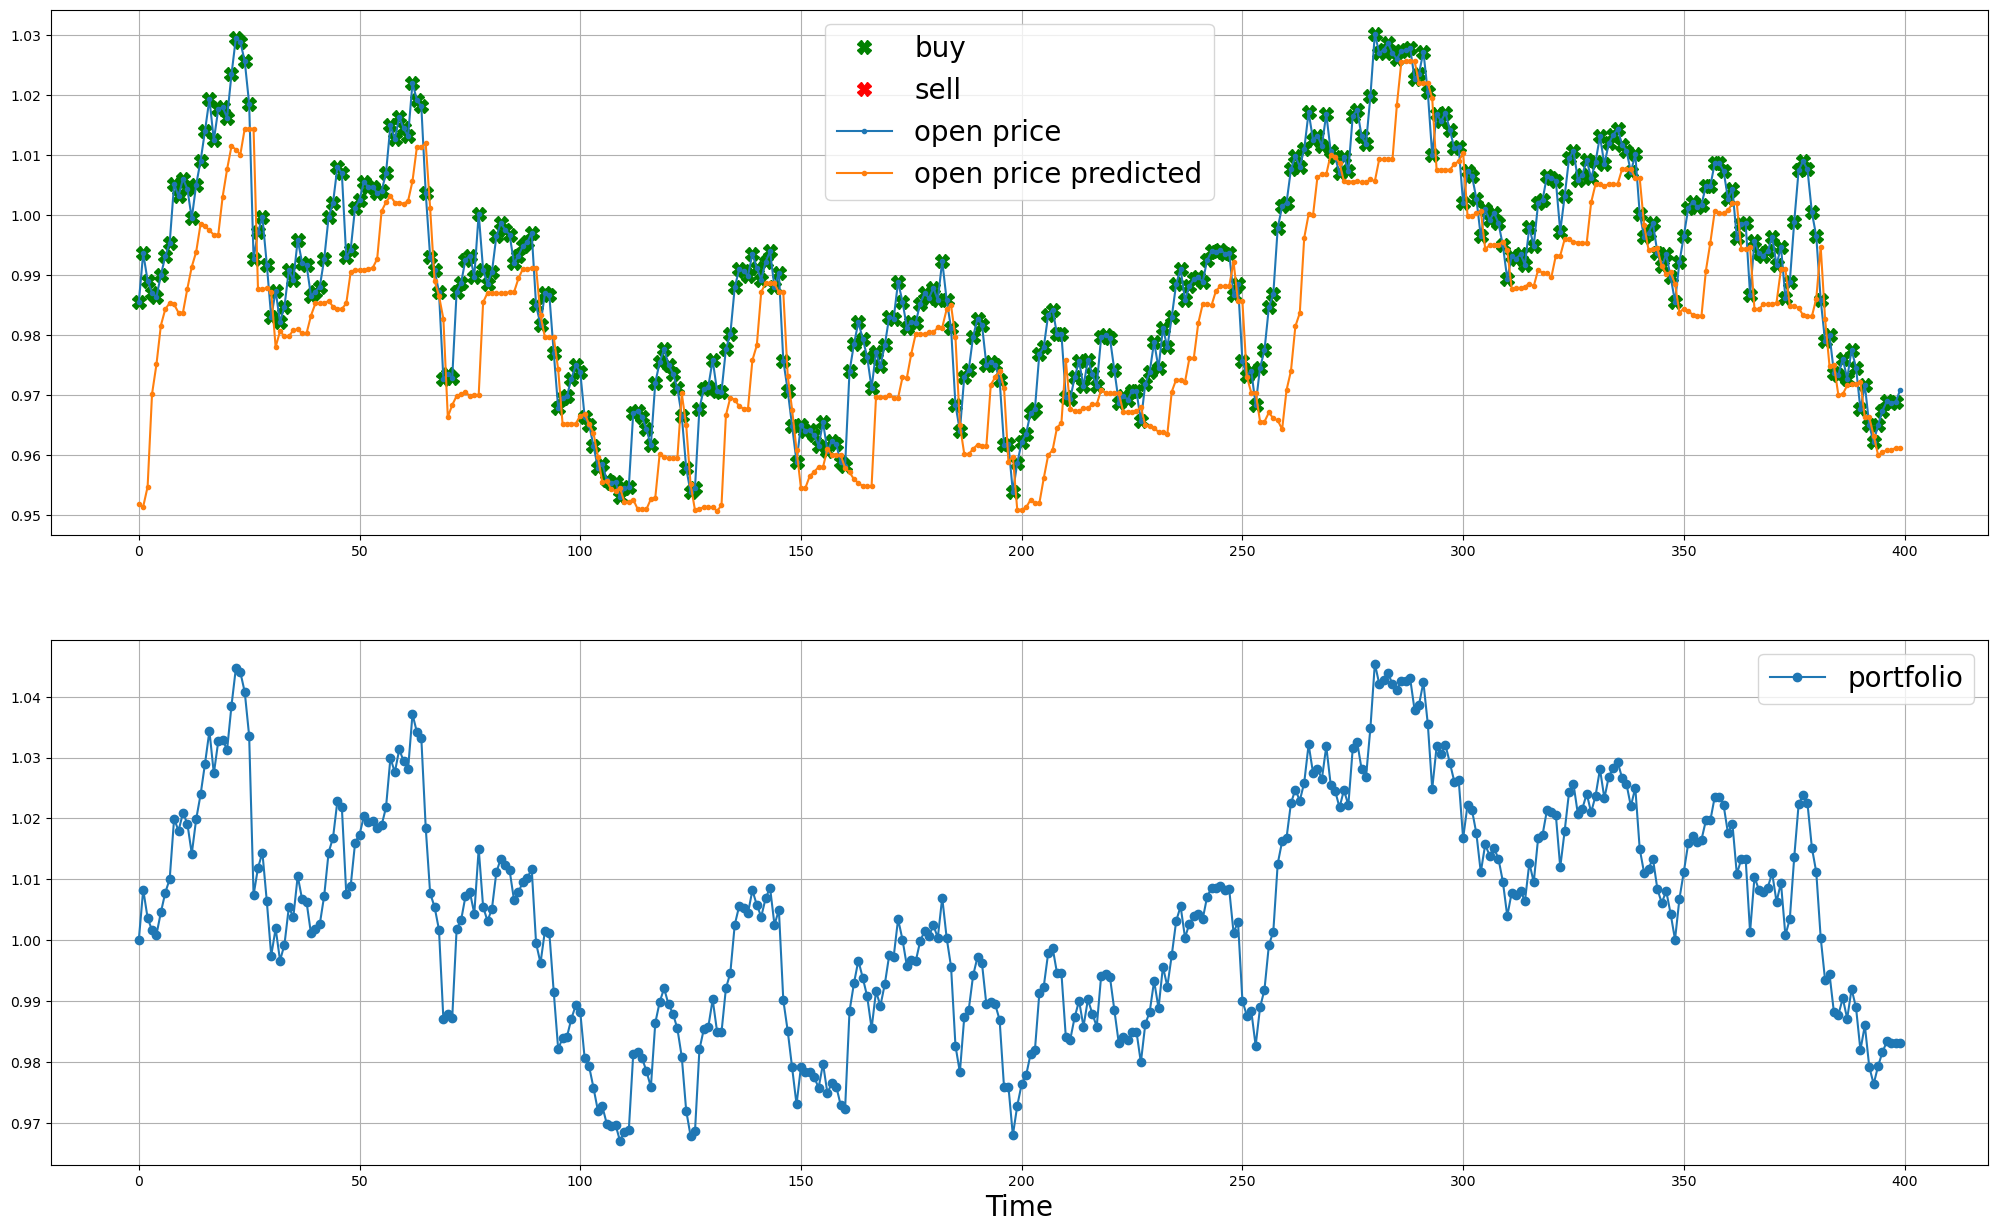

gain = -1.68%


MSE           0.000271
ACC           0.446352
MEAN RET %   -0.002962
Name: LSTM_AE, dtype: float64

In [72]:
outputs_LSTM_AE, targets, MSE = pl.evaluate(model_LSTM_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE = pp.min_max_norm_inverse(outputs_LSTM_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE = np.mean((outputs_LSTM_AE-t)**2)
ACC_LSTM_AE = pl.direction_accuracy(outputs_LSTM_AE, t)
MEAN_RET_LSTM_AE = pl.evauate_strategy(t, outputs_LSTM_AE, plot=True, tax=1)

result_price_df['LSTM_AE'] = [MSE_LSTM_AE, ACC_LSTM_AE, MEAN_RET_LSTM_AE]
result_price_df['LSTM_AE']

##### GRU + AE

In [73]:
model_GRU_AE = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_AE.to(device)
model_GRU_AE

GRU_base(
  (gru): GRU(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 12%|█▏        | 116/1000 [00:40<05:09,  2.85it/s]


0.4710582309961319 < 0.47108966469764707
Epoch: 117/1000
MSE = [train loss mean :  0.65484365] , [val loss mean:  0.48337734, MSE (last) 47.09252%]


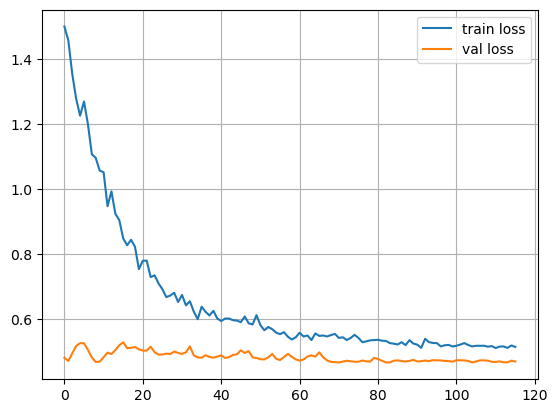

In [74]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

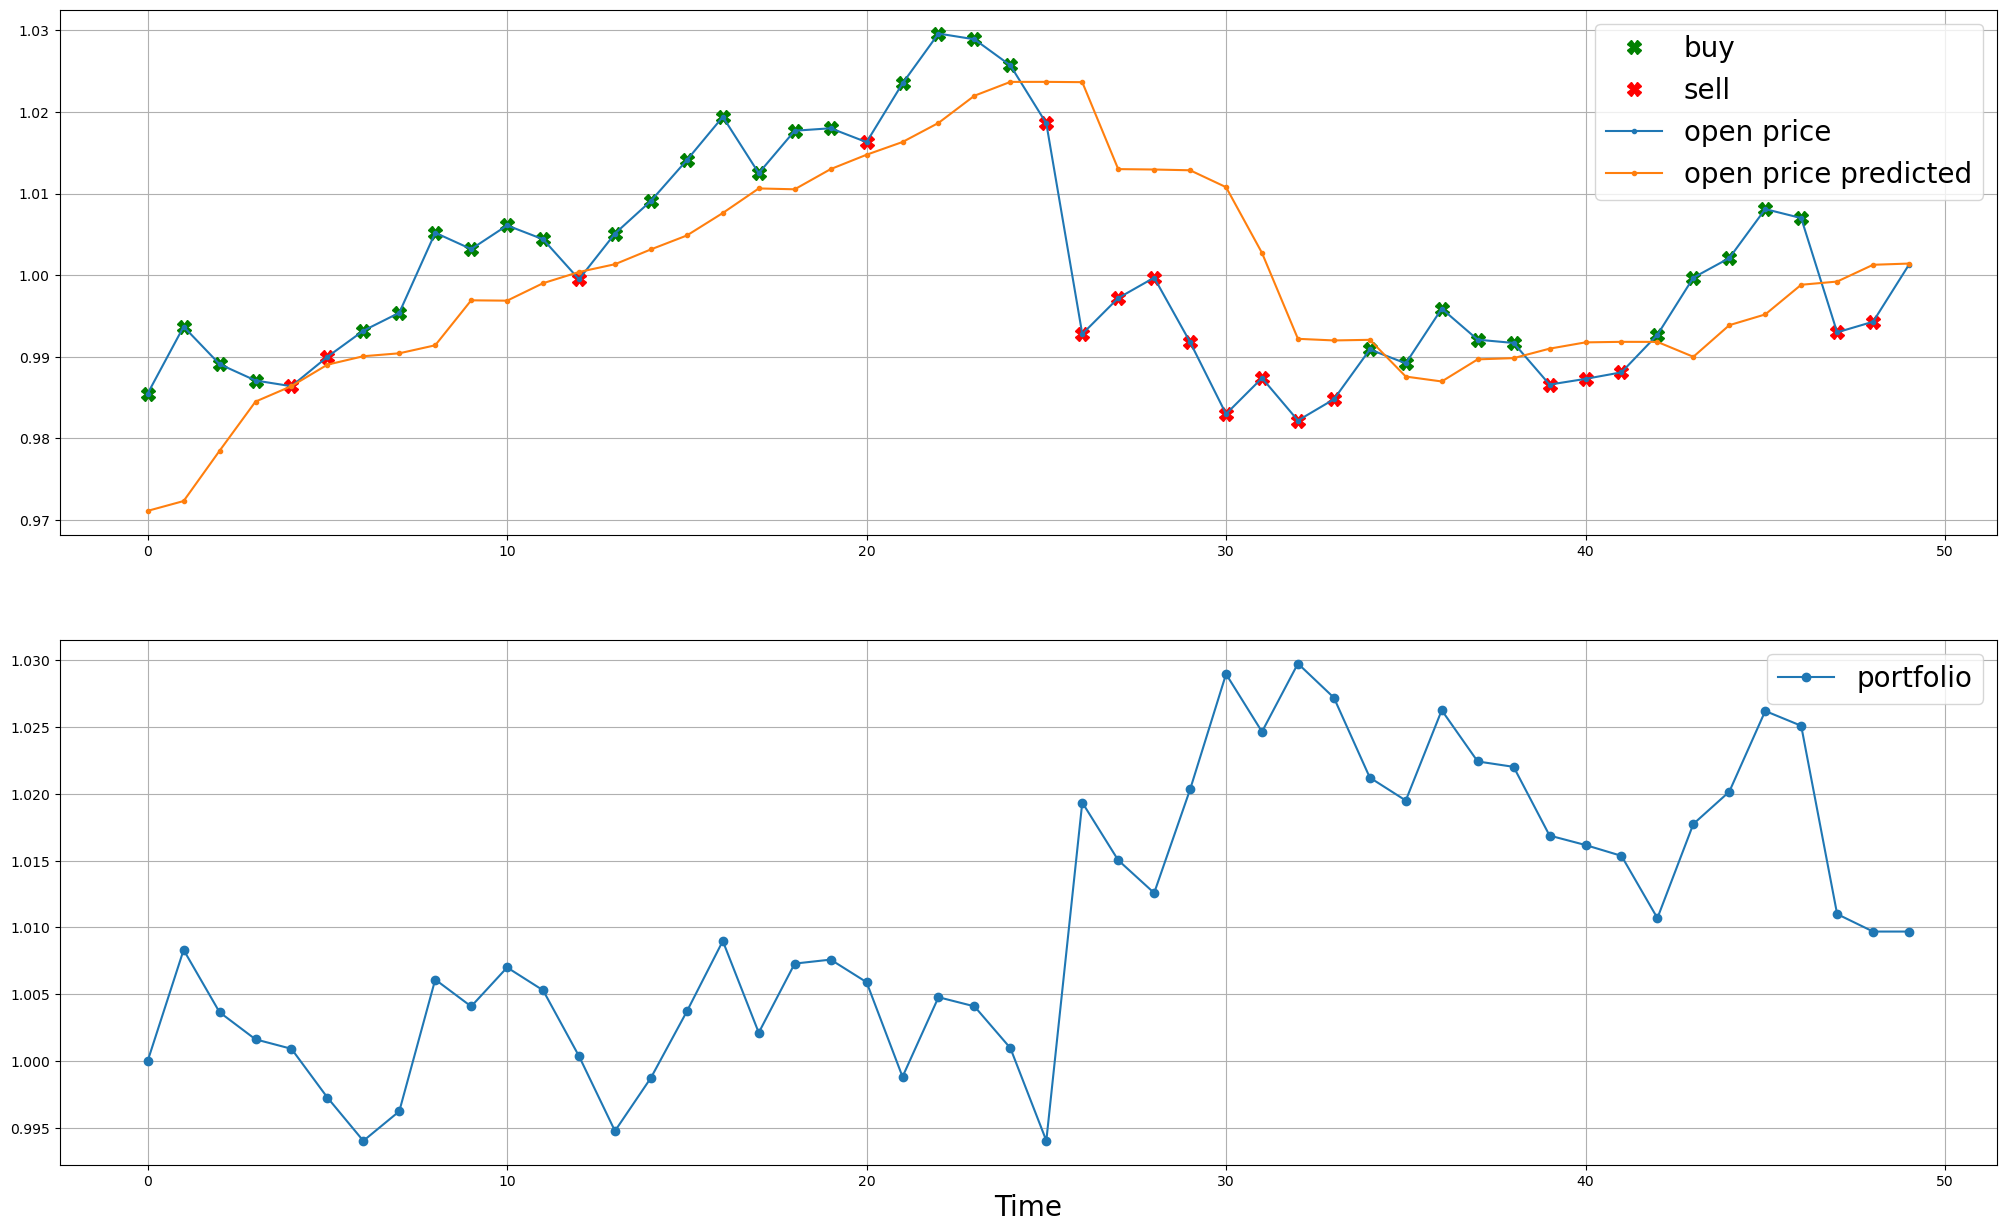

gain = 0.97%


MSE           0.000157
ACC           0.520744
MEAN RET %    0.021576
Name: GRU_AE, dtype: float64

In [75]:
outputs_GRU_AE, targets, MSE = pl.evaluate(model_GRU_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE = pp.min_max_norm_inverse(outputs_GRU_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE = np.mean((outputs_GRU_AE-t)**2)
ACC_GRU_AE = pl.direction_accuracy(outputs_GRU_AE, t)
MEAN_RET_GRU_AE = pl.evauate_strategy(t, outputs_GRU_AE, start=300, end=350, plot=True, tax=1)

result_price_df['GRU_AE'] = [MSE_GRU_AE, ACC_GRU_AE, MEAN_RET_GRU_AE]
result_price_df['GRU_AE']

#### Add Regularized Loss: $L = \sum (y- \hat{y})^2 + \lambda \sum ((y- y_{prev})(y- \hat{y}))^2 $

##### Dense + AE + REG

In [76]:
model_Dense_AE_REG = ml.Dense(
    num_layers = 2,
    layer_size = 32,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.05)
model_Dense_AE_REG.to(device)
model_Dense_AE_REG

Dense(
  (net): Sequential(
    (0): Linear(in_features=216, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

 10%|█         | 100/1000 [00:08<01:20, 11.23it/s]


0.47612074788411457 < 0.47957410375622733
Epoch: 101/1000
MSE = [train loss mean :  0.59063915] , [val loss mean:  0.59605571, MSE (last) 16269.86389%]


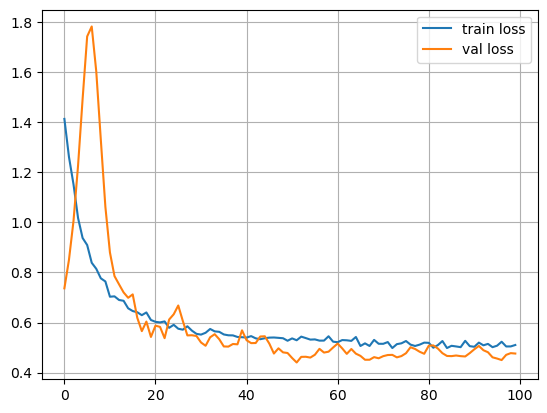

In [77]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_Dense_AE_REG,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lambda_=0.01,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show()

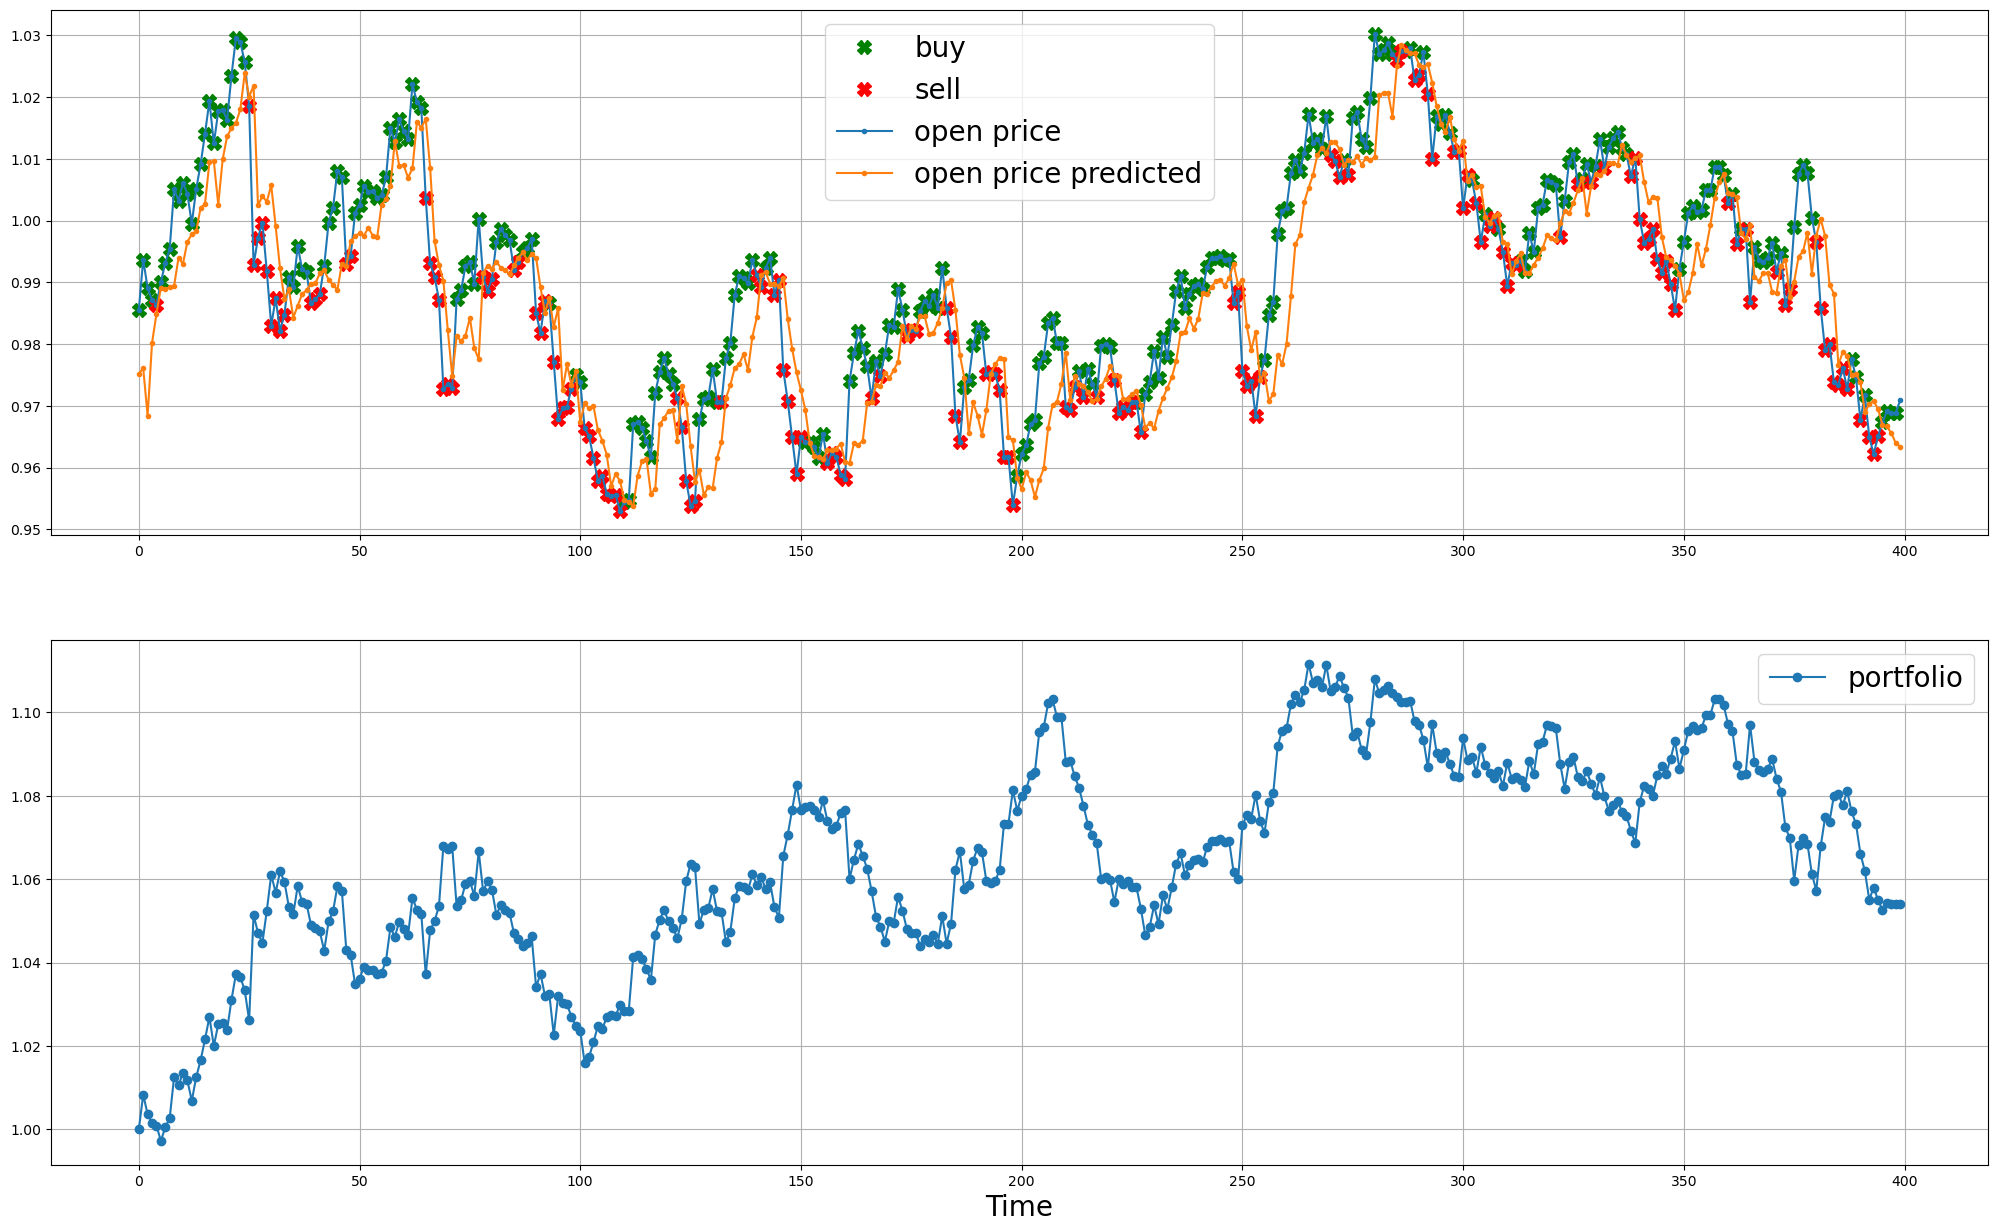

gain = 5.42%


MSE           0.000141
ACC           0.519313
MEAN RET %    0.014369
Name: Dense_AE_REG, dtype: float64

In [78]:

outputs_Dense_AE_REG, targets, MSE = pl.evaluate(model_Dense_AE_REG, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE_REG = pp.min_max_norm_inverse(outputs_Dense_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE_REG = np.mean((outputs_Dense_AE_REG-t)**2)
ACC_Dense_AE_REG = pl.direction_accuracy(outputs_Dense_AE_REG, t)
MEAN_RET_Dense_AE_REG = pl.evauate_strategy(t, outputs_Dense_AE_REG,plot=True, tax=1)

result_price_df['Dense_AE_REG'] = [MSE_Dense_AE_REG, ACC_Dense_AE_REG, MEAN_RET_Dense_AE_REG]
result_price_df['Dense_AE_REG']

##### LSTM + AE + REG

In [79]:
model_LSTM_AE_REG = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE_REG.to(device)
model_LSTM_AE_REG

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 10%|█         | 102/1000 [00:27<04:05,  3.66it/s]

0.4682356956592504 < 0.4682721318783967
Epoch: 103/1000
MSE = [train loss mean :  0.74478366] , [val loss mean:  0.46976119, MSE (last) 16212.60376%]


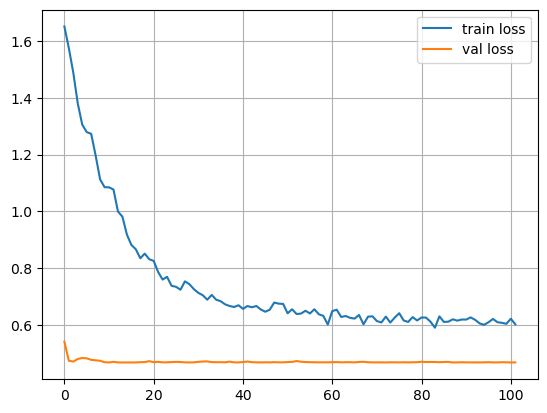

In [80]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_LSTM_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=0.1,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.savefig("loss.svg")
plt.show() 

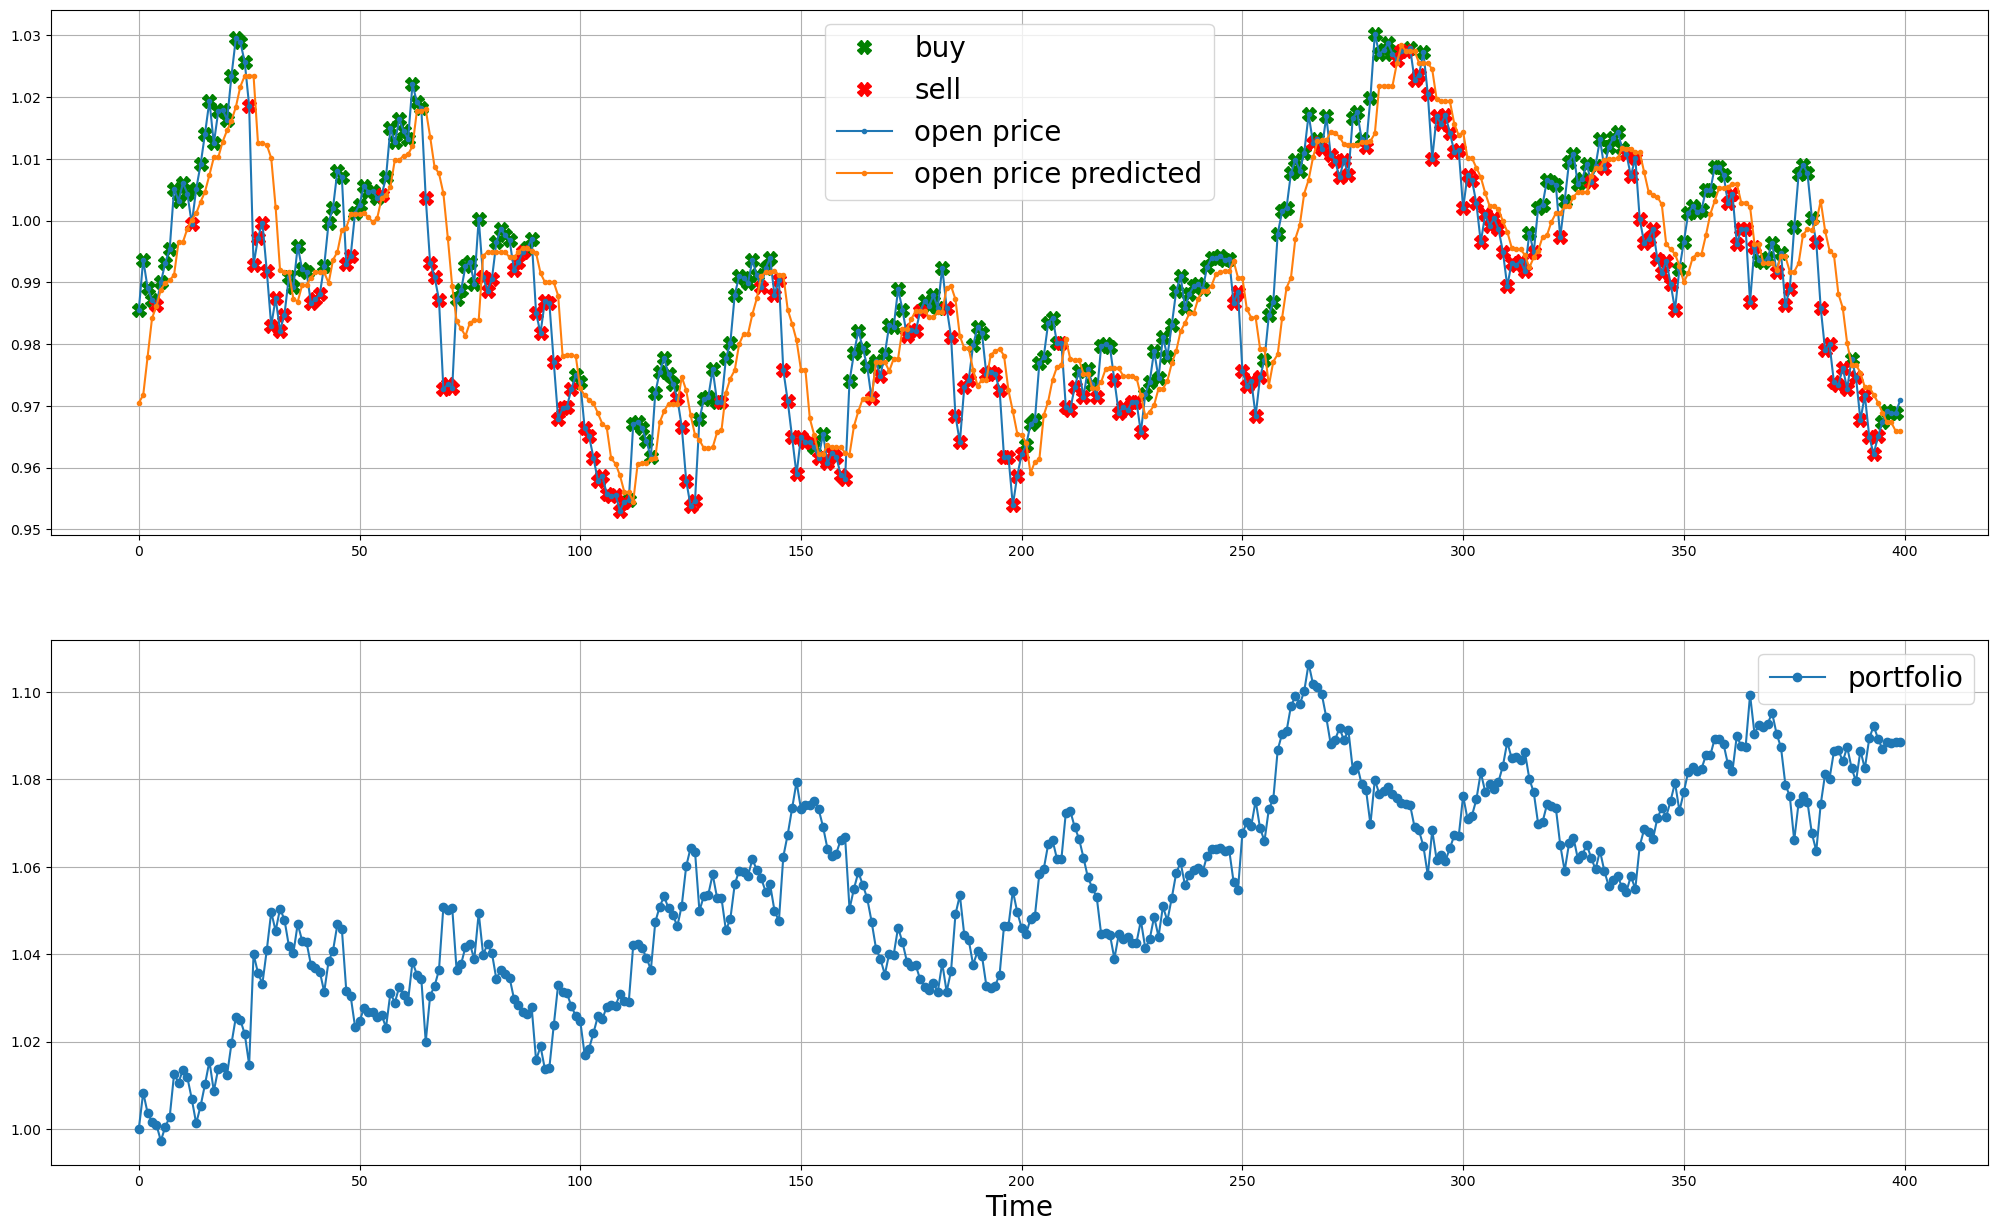

gain = 8.85%


MSE           0.000155
ACC           0.517883
MEAN RET %    0.022416
Name: LSTM_AE_REG, dtype: float64

In [81]:
outputs_LSTM_AE_REG, targets, MSE = pl.evaluate(model_LSTM_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE_REG = pp.min_max_norm_inverse(outputs_LSTM_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE_REG = np.mean((outputs_LSTM_AE_REG-t)**2)
ACC_LSTM_AE_REG = pl.direction_accuracy(outputs_LSTM_AE_REG, t)
MEAN_RET_LSTM_AE_REG = pl.evauate_strategy(t, outputs_LSTM_AE_REG, plot=True, tax=1)

result_price_df['LSTM_AE_REG'] = [MSE_LSTM_AE_REG, ACC_LSTM_AE_REG, MEAN_RET_LSTM_AE_REG]
result_price_df['LSTM_AE_REG'] 

##### GRU + AE + REG

In [82]:
model_GRU_AE_REG = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_AE_REG.to(device)
model_GRU_AE_REG

GRU_base(
  (gru): GRU(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 17%|█▋        | 167/1000 [00:30<02:32,  5.47it/s]


0.47692726997707197 < 0.4774913453917573
Epoch: 168/1000
MSE = [train loss mean :  1.51547612] , [val loss mean:  0.48334517, MSE (last) 16947.84698%]


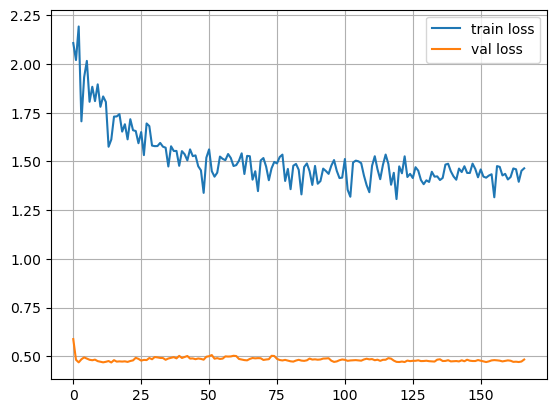

In [83]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_GRU_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=1,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

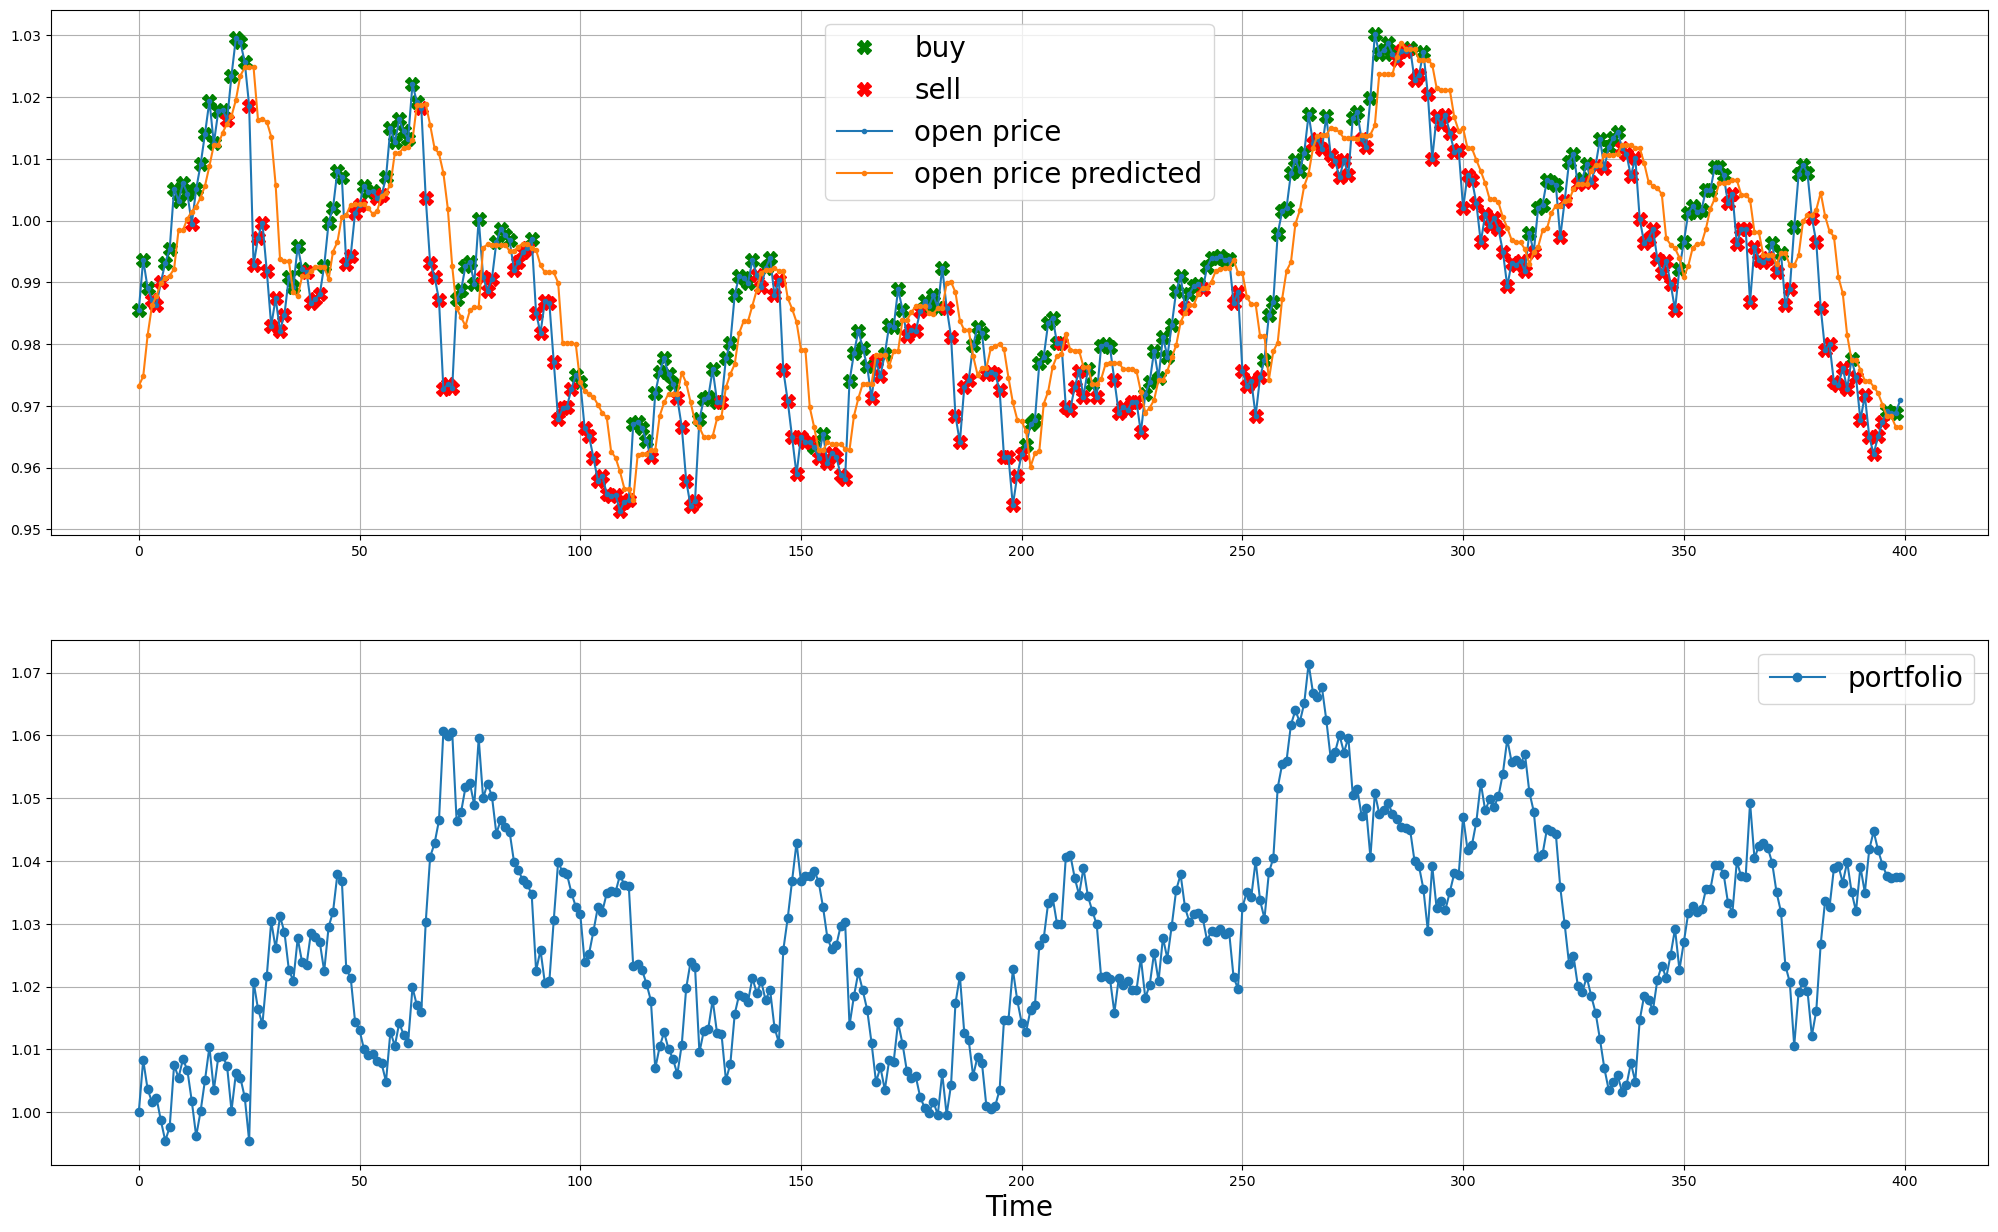

gain = 3.74%


MSE           0.000175
ACC           0.522175
MEAN RET %    0.010431
Name: GRU_AE_REG, dtype: float64

In [84]:
outputs_GRU_AE_REG, targets, MSE = pl.evaluate(model_GRU_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE_REG = pp.min_max_norm_inverse(outputs_GRU_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE_REG = np.mean((outputs_GRU_AE_REG-t)**2)
ACC_GRU_AE_REG = pl.direction_accuracy(outputs_GRU_AE_REG, t)
MEAN_RET_GRU_AE_REG = pl.evauate_strategy(t, outputs_GRU_AE_REG, plot=True, tax=1)

result_price_df['GRU_AE_REG'] = [MSE_GRU_AE_REG, ACC_GRU_AE_REG, MEAN_RET_GRU_AE_REG]
result_price_df['GRU_AE_REG']

### Trend prediction

#### Baseline

##### Dense 

In [85]:
model_Dense_Trend = ml.Dense(
    num_layers = 2,
    layer_size = 32,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.05)
model_Dense_Trend.to(device)
model_Dense_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=216, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

 12%|█▏        | 115/1000 [00:11<01:27, 10.10it/s]


0.7763401675224304 < 0.7763737726211548
Epoch: 116/1000
MSE = [train loss mean :  0.69881946] , [val loss mean:  0.78833673, MSE (last) 77.67100%]


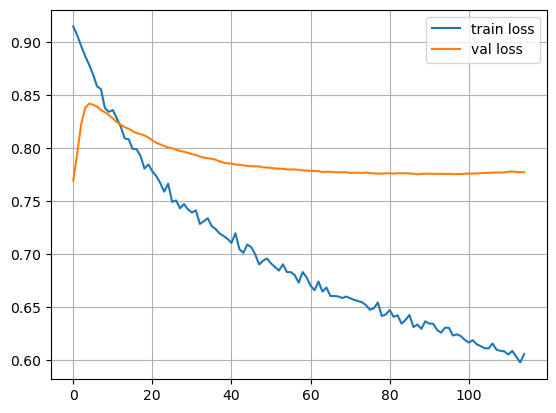

In [86]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_Trend,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

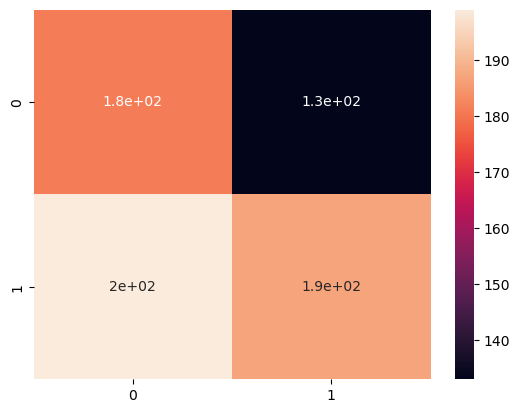

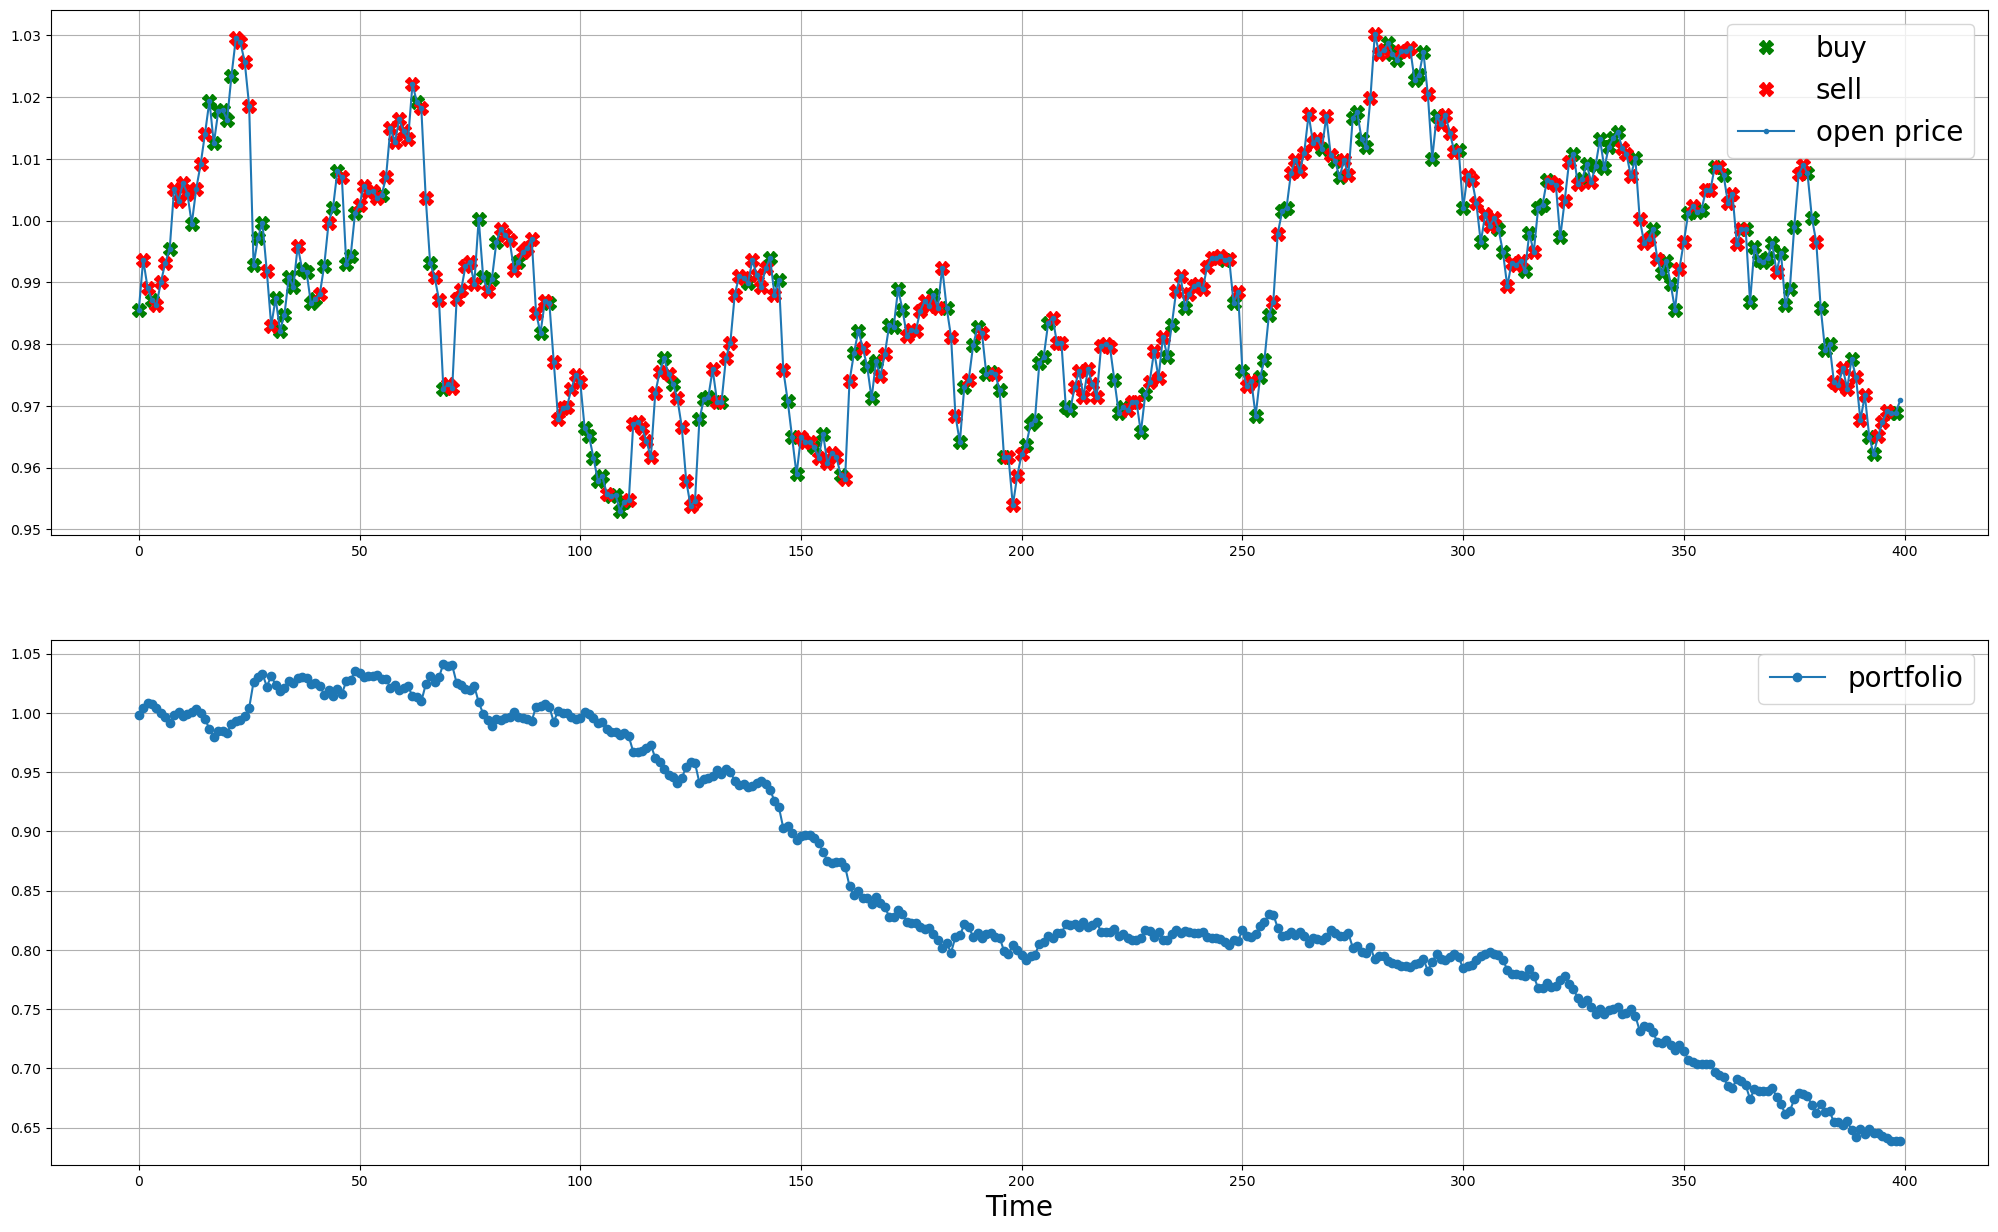

ACC           0.525714
MEAN RET %   -0.110008
Name: Dense, dtype: float64

In [87]:
outputs_Dense_Trend, targets, ACC_Dense_Trend = pl.evaluate_trend(model_Dense_Trend, test_x.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_Trend = pl.evauate_strategy_trend(t, outputs_Dense_Trend,plot=True, tax=1)

result_trend_df['Dense'] = [ACC_Dense_Trend, MEAN_RET_Dense_Trend]
result_trend_df['Dense']

##### LSTM

In [88]:
model_LSTM_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_Trend.to(device)
model_LSTM_Trend

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  7%|▋         | 70/1000 [00:20<04:28,  3.47it/s]

0.7691188979148865 < 0.7693179249763489
Epoch: 71/1000
MSE = [train loss mean :  0.74911778] , [val loss mean:  0.76928787, MSE (last) 77.23302%]


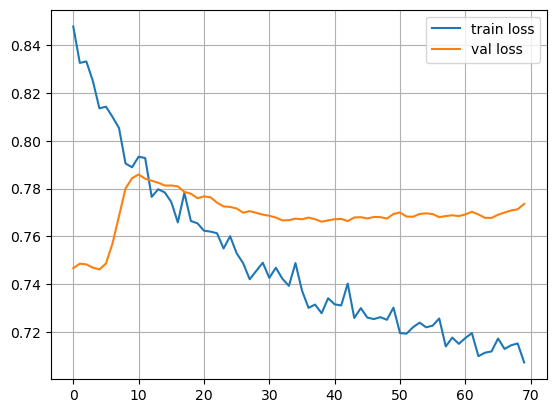

In [89]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

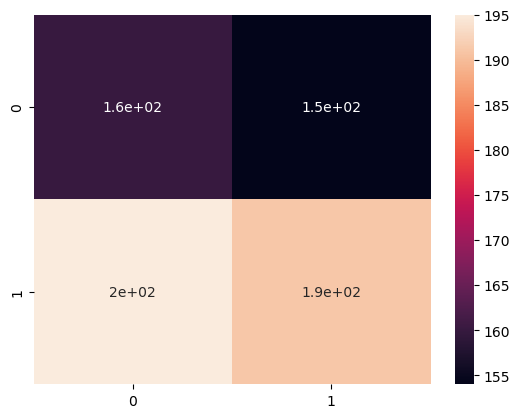

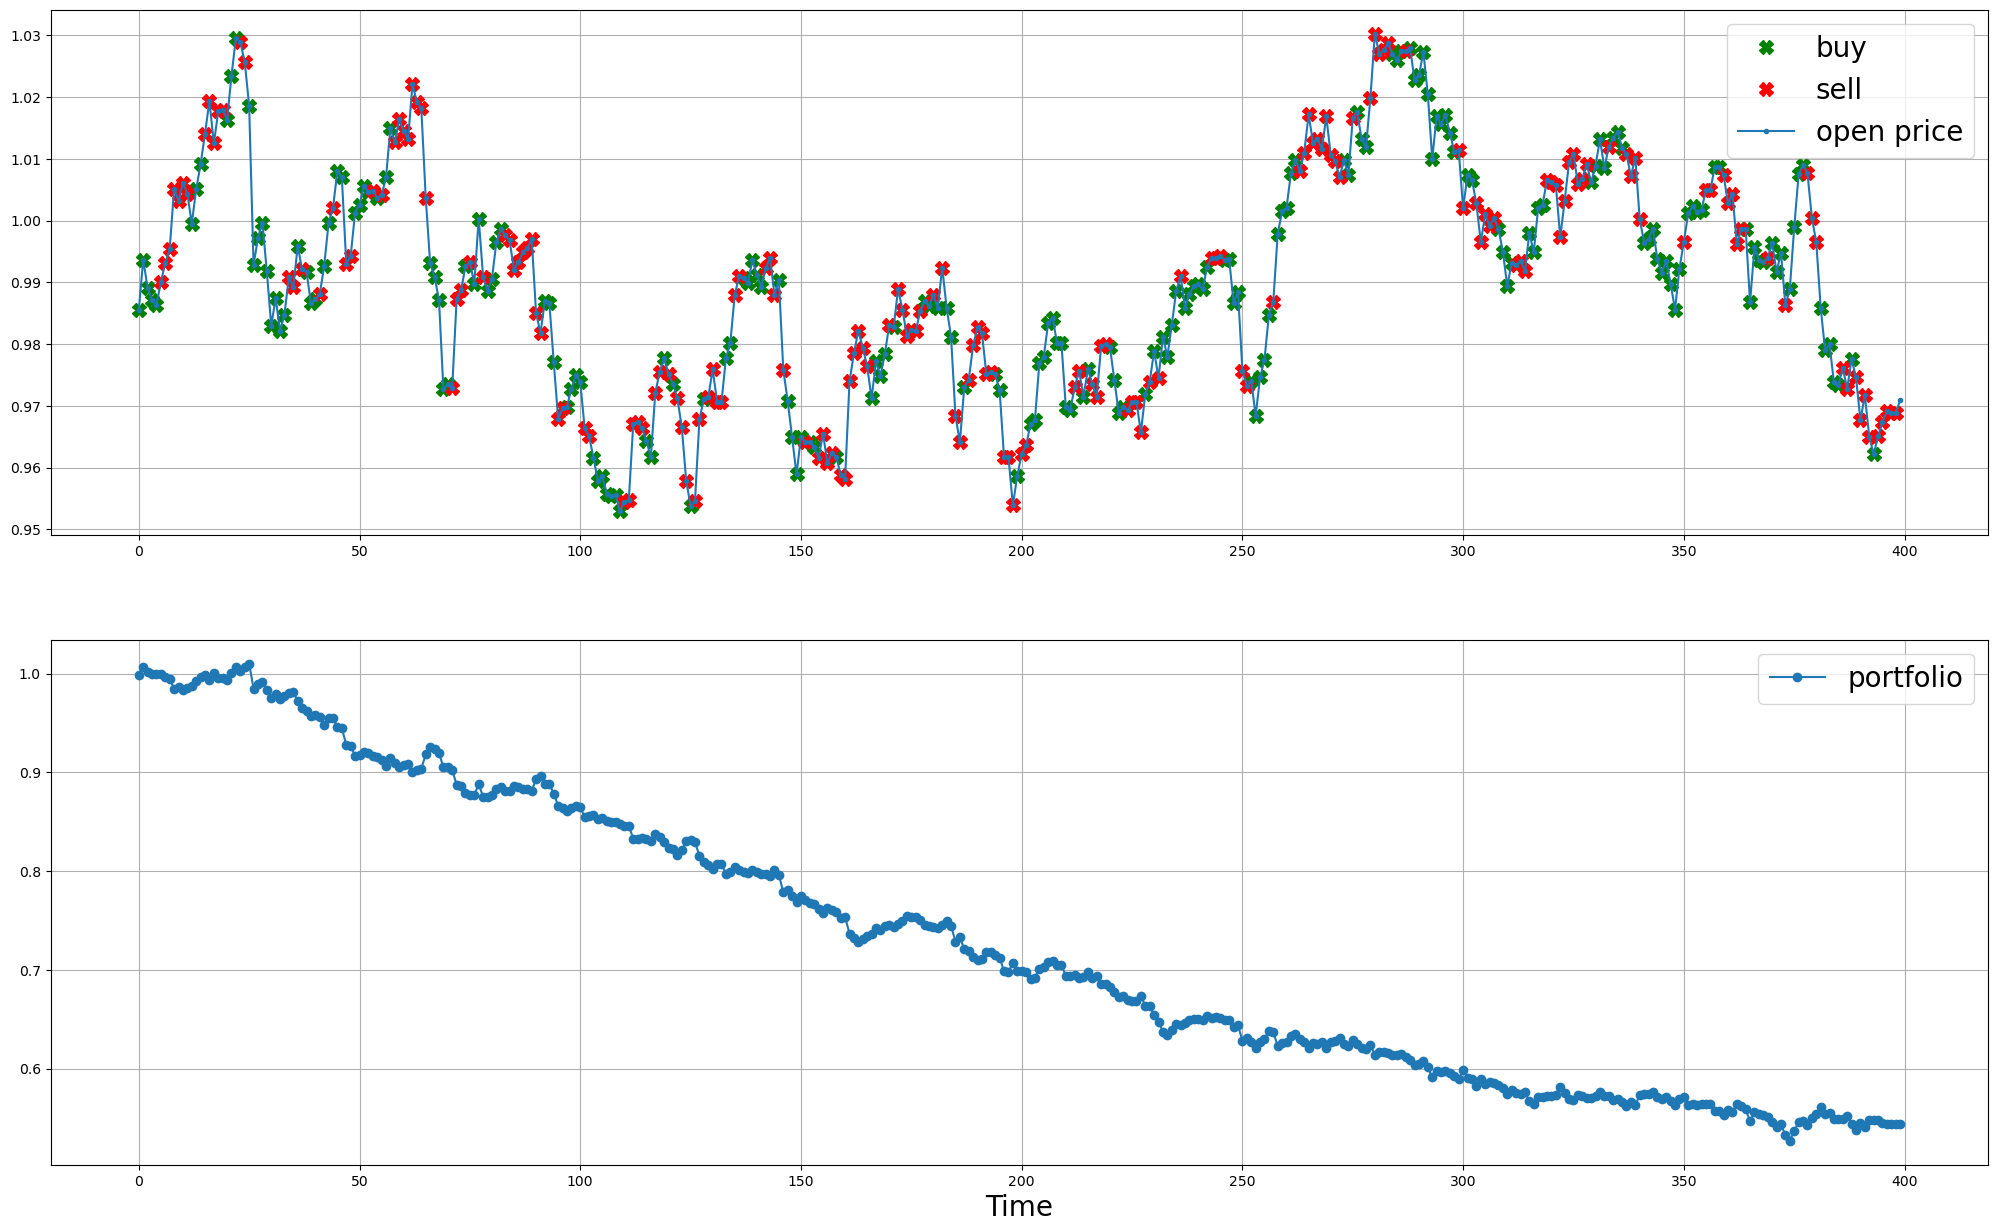

ACC           0.501429
MEAN RET %   -0.149459
Name: LSTM, dtype: float64

In [90]:
outputs_LSTM_Trend, targets, ACC_LSTM_Trend = pl.evaluate_trend(model_LSTM_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_Trend,plot=True, tax=1)

result_trend_df['LSTM'] = [ACC_LSTM_Trend, MEAN_RET_LSTM_Trend]
result_trend_df['LSTM']

##### GRU

In [91]:
model_GRU_Trend = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_Trend.to(device)
model_GRU_Trend

GRU_base(
  (gru): GRU(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 14%|█▍        | 142/1000 [00:33<03:25,  4.18it/s]

0.7697484803199768 < 0.7698241686820984
Epoch: 143/1000
MSE = [train loss mean :  0.73187130] , [val loss mean:  0.77571845, MSE (last) 77.06102%]


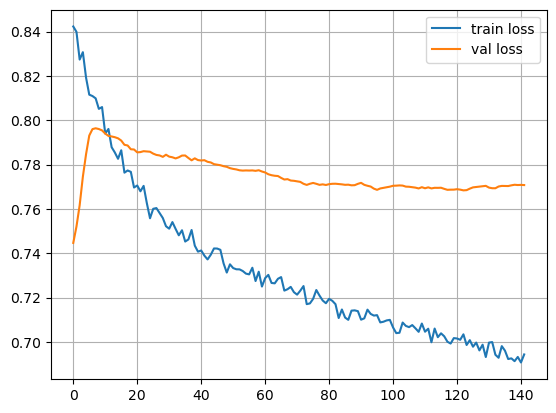

In [92]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

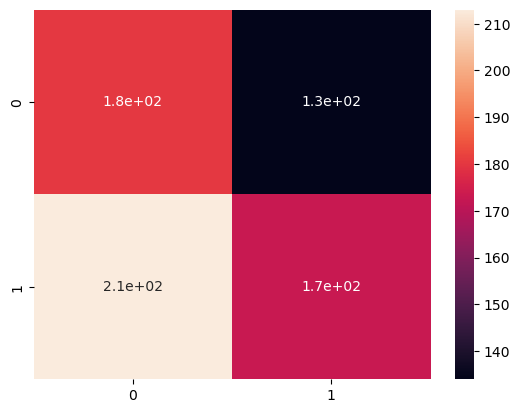

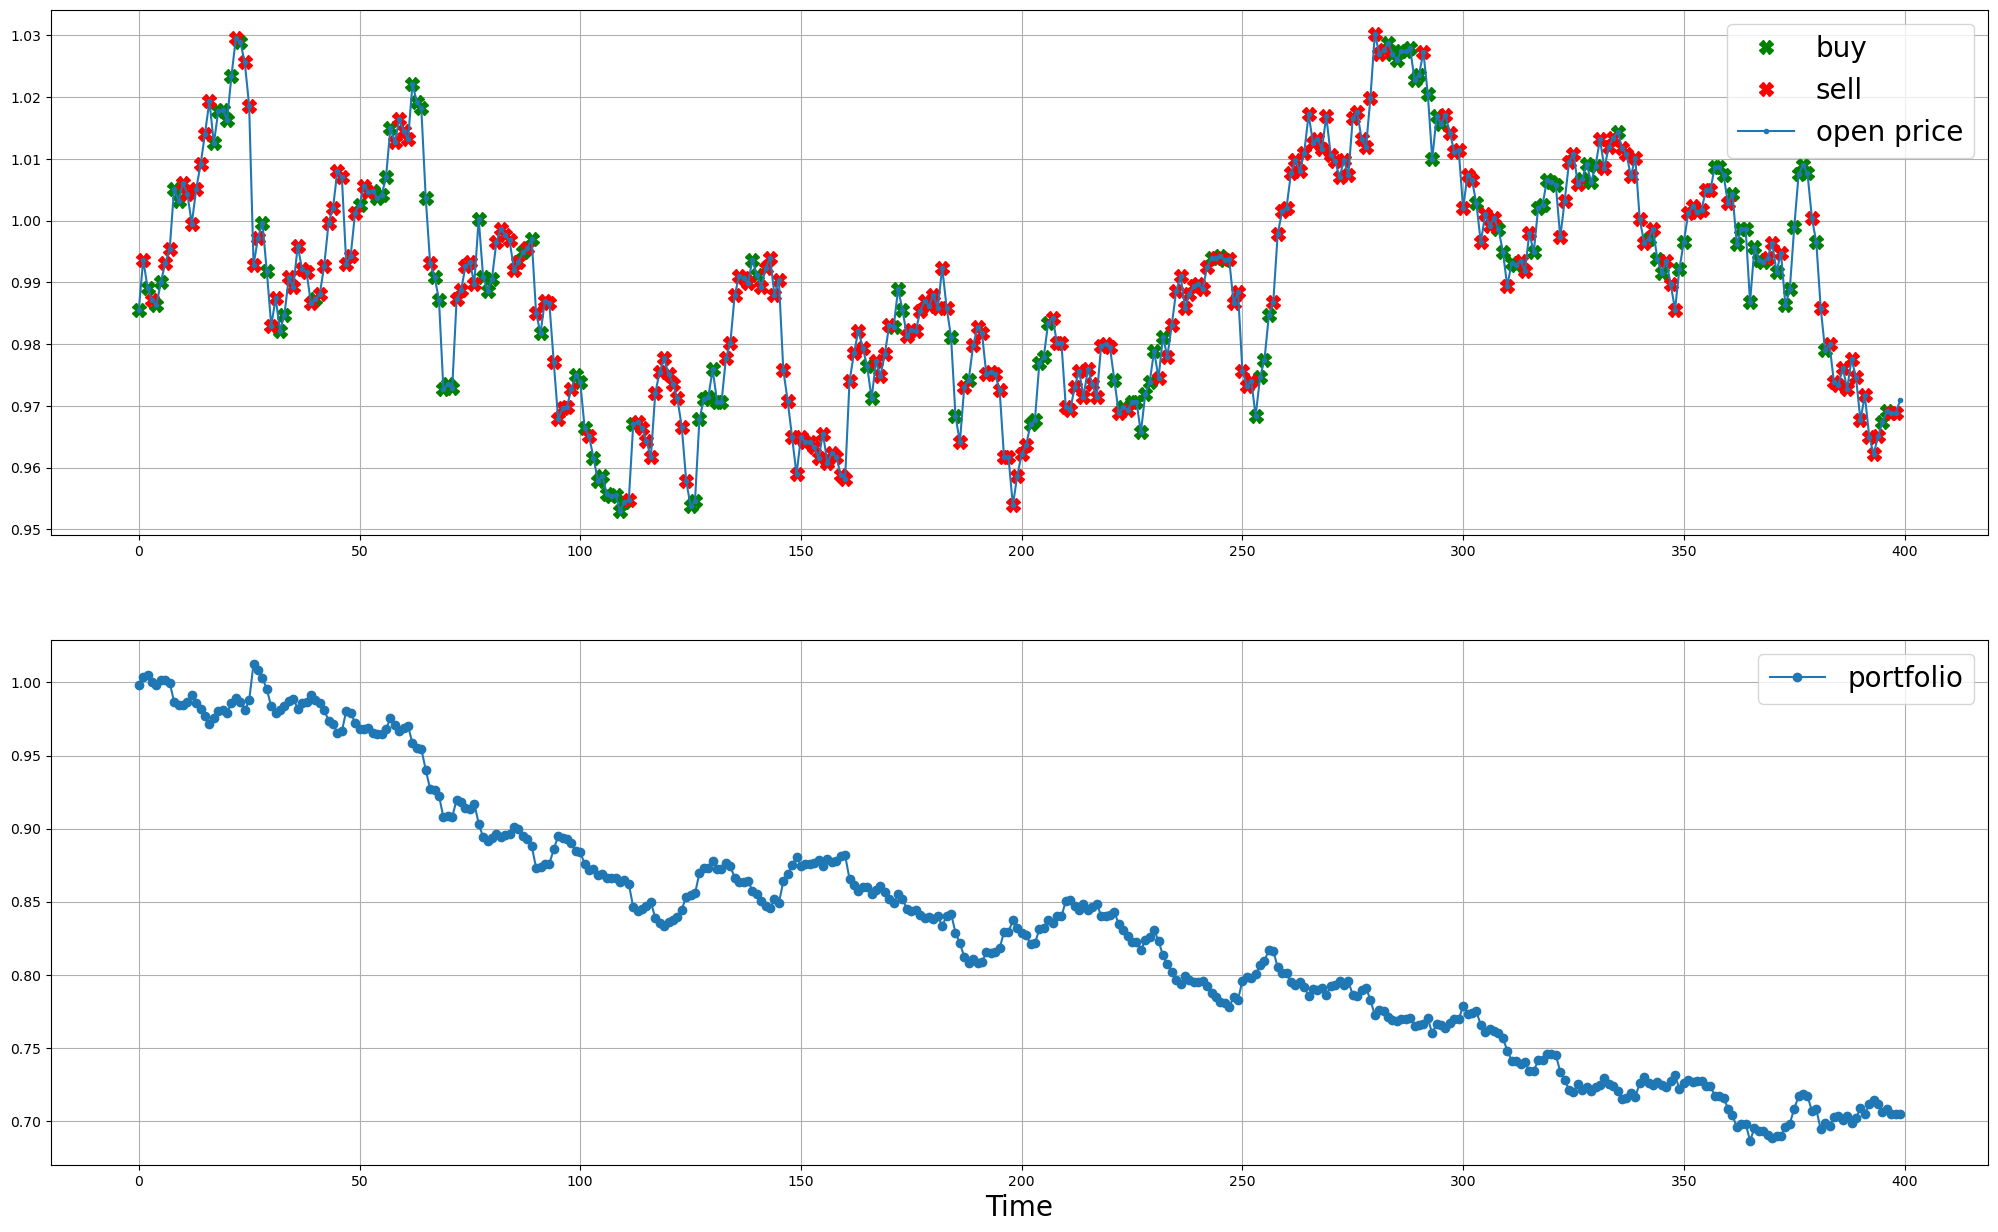

ACC           0.504286
MEAN RET %   -0.085370
Name: GRU, dtype: float64

In [93]:
outputs_GRU_Trend, targets, ACC_GRU_Trend = pl.evaluate_trend(model_GRU_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_Trend = pl.evauate_strategy_trend(t, outputs_GRU_Trend, plot=True, tax=1)

result_trend_df['GRU'] = [ACC_GRU_Trend, MEAN_RET_GRU_Trend]
result_trend_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [94]:
model_Dense_AE_Trend = ml.Dense(
    num_layers = 2,
    layer_size = 32,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.05)
model_Dense_AE_Trend.to(device)
model_Dense_AE_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=216, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

  8%|▊         | 85/1000 [00:06<01:10, 12.93it/s]


0.7958679747581482 < 0.7980878686904908
Epoch: 86/1000
MSE = [train loss mean :  0.79875526] , [val loss mean:  0.80172244, MSE (last) 82.15259%]


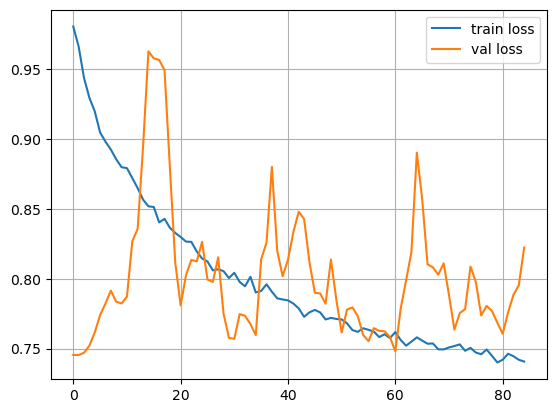

In [95]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE_Trend,
    train_x_ = train_x_smooth.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

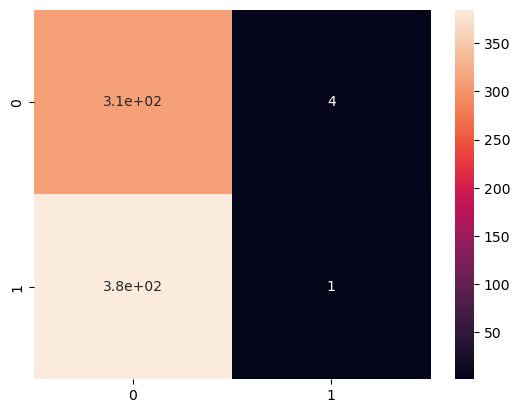

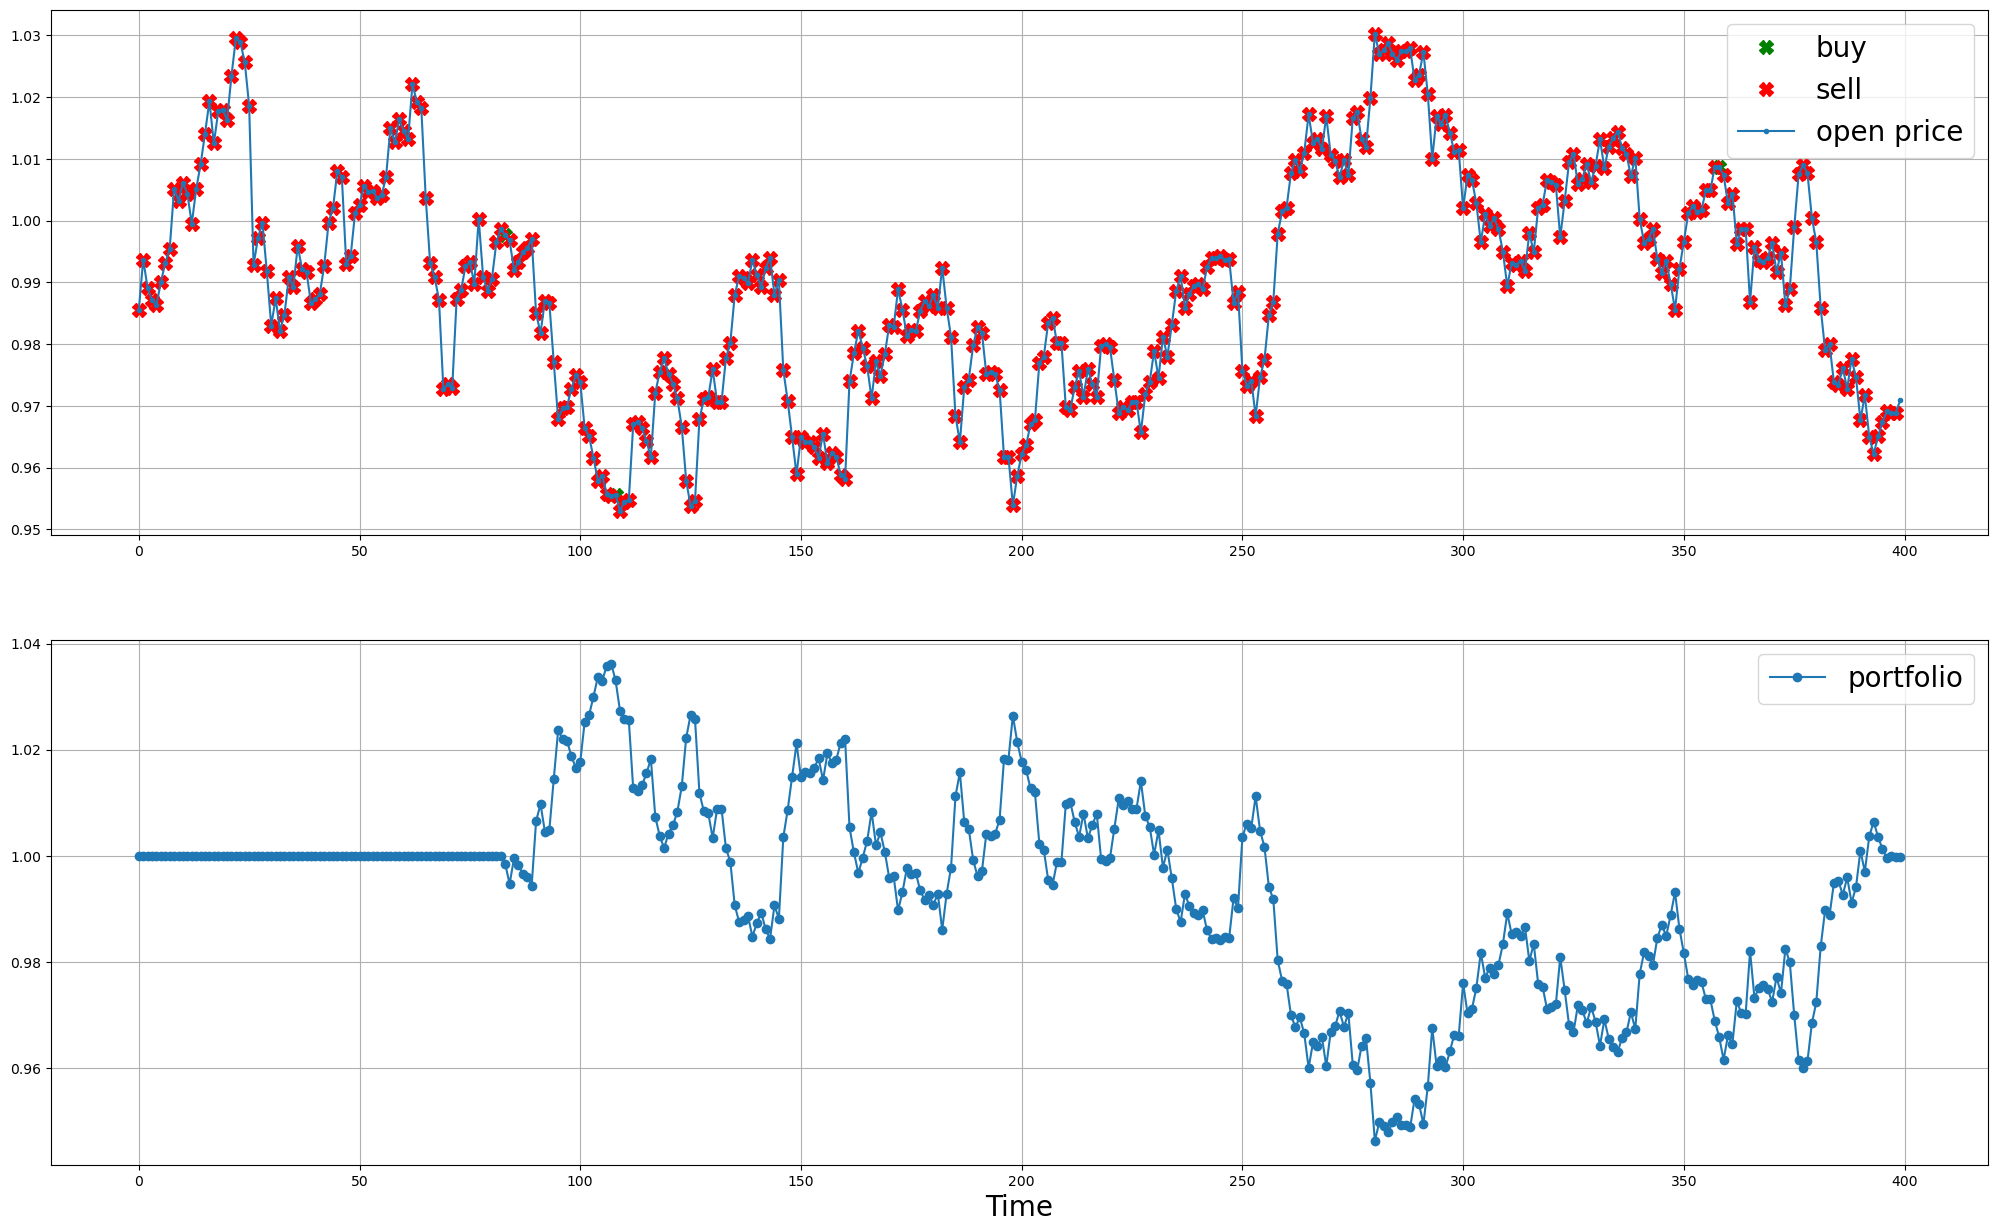

ACC           0.444286
MEAN RET %    0.000907
Name: Dense_AE, dtype: float64

In [96]:
outputs_Dense_AE_Trend, targets, ACC_Dense_AE_Trend = pl.evaluate_trend(model_Dense_AE_Trend, test_x_smooth.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_AE_Trend = pl.evauate_strategy_trend(t, outputs_Dense_AE_Trend,plot=True, tax=1)

result_trend_df['Dense_AE'] = [ACC_Dense_AE_Trend, MEAN_RET_Dense_AE_Trend]
result_trend_df['Dense_AE']

##### LSTM + AE

In [97]:
model_LSTM_AE_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE_Trend.to(device)
model_LSTM_AE_Trend

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  9%|▉         | 94/1000 [00:24<03:58,  3.80it/s]

0.7444618761539459 < 0.744472496509552
Epoch: 95/1000
MSE = [train loss mean :  0.75670324] , [val loss mean:  0.74497801, MSE (last) 74.42064%]


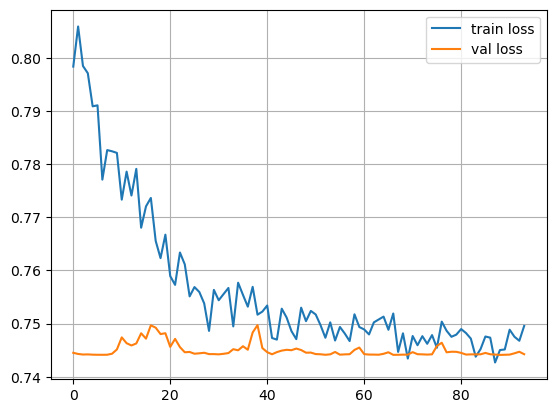

In [98]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

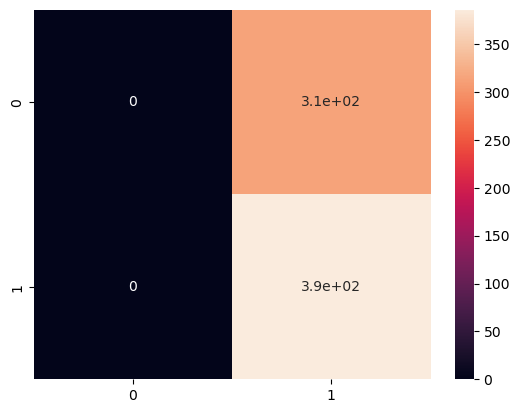

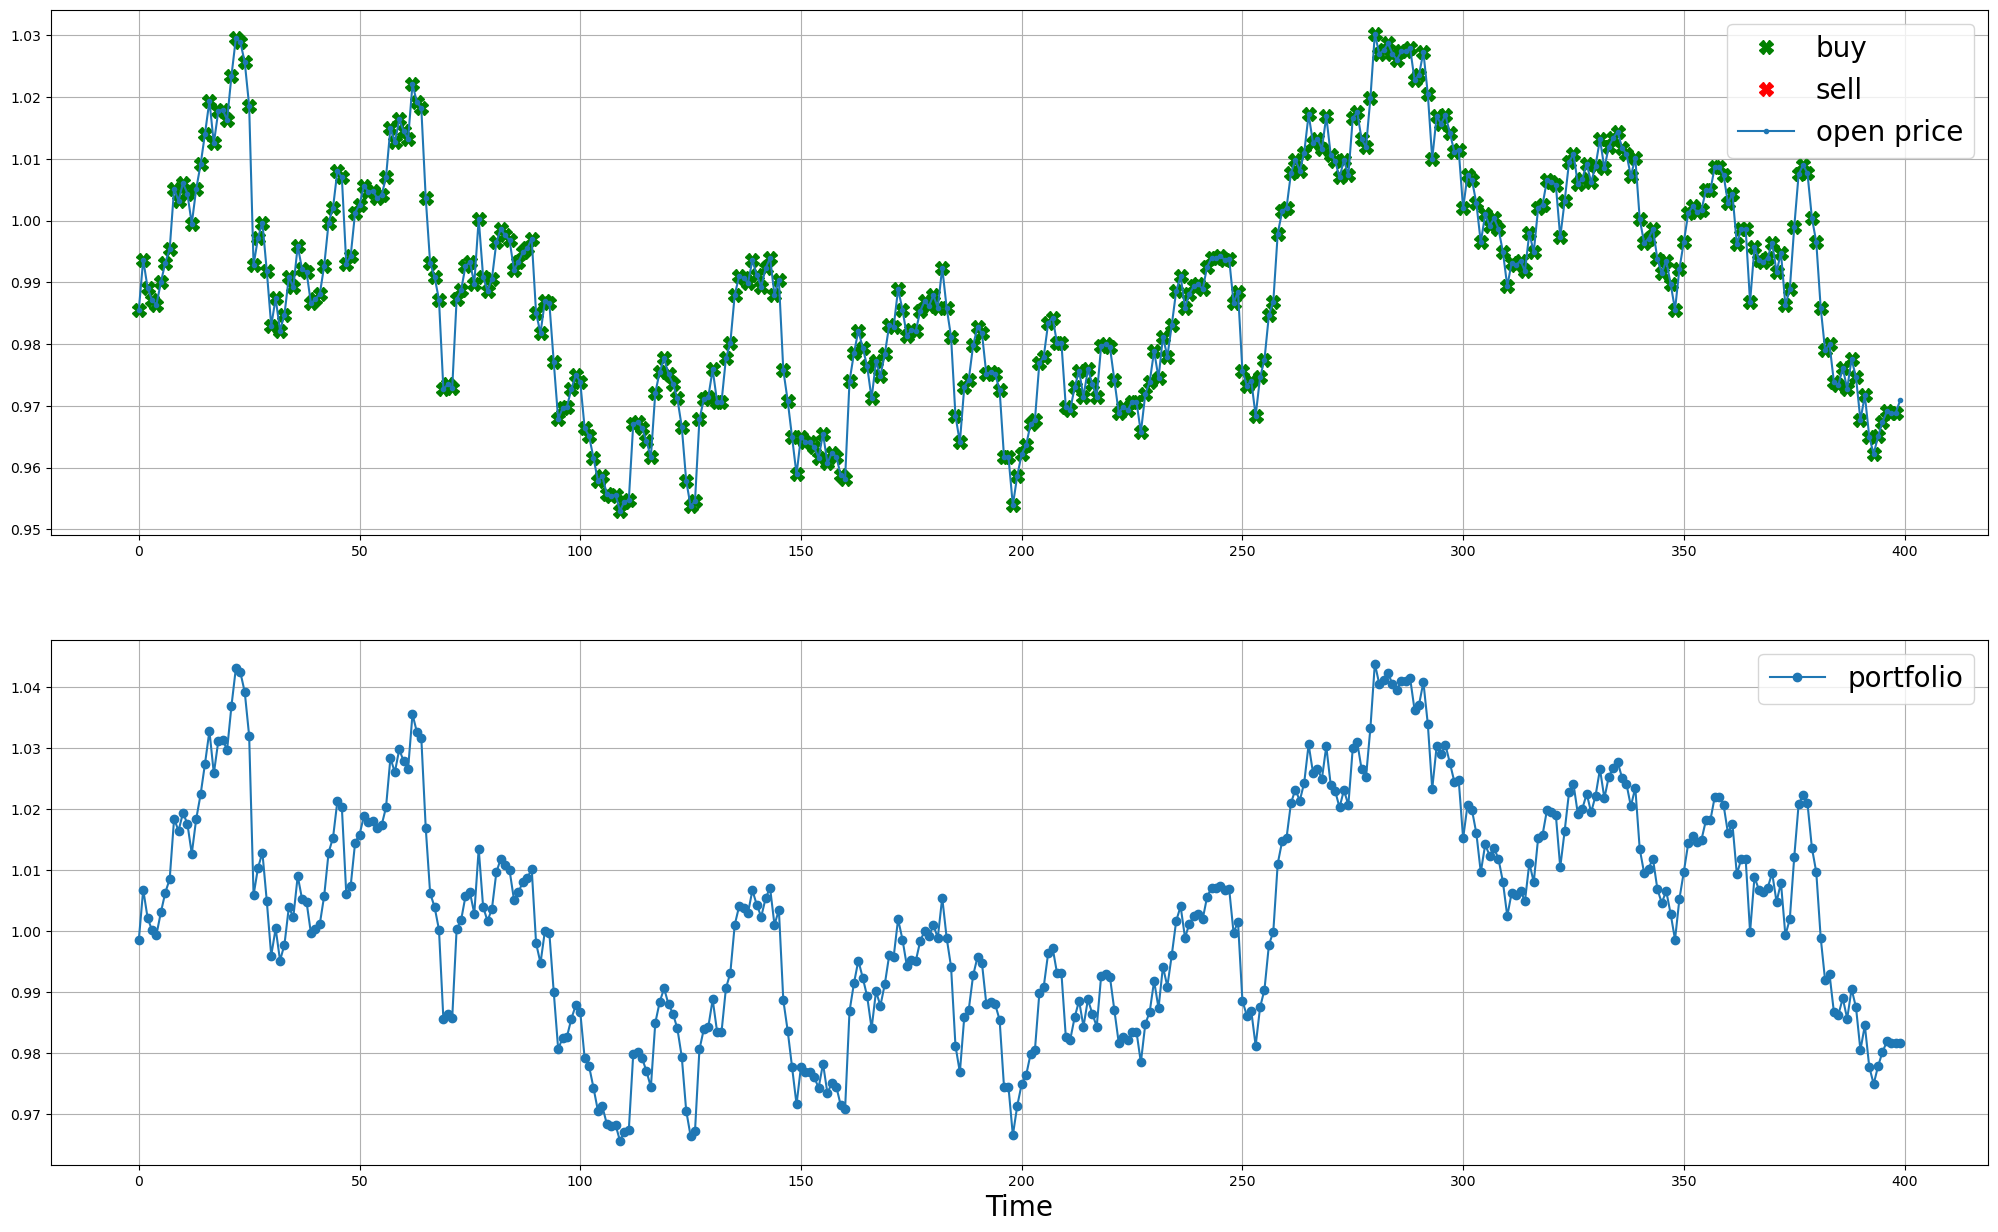

ACC           0.551429
MEAN RET %   -0.002962
Name: LSTM_AE, dtype: float64

In [99]:
outputs_LSTM_AE_Trend, targets, ACC_LSTM_AE_Trend = pl.evaluate_trend(model_LSTM_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_AE_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_AE_Trend,plot=True)

result_trend_df['LSTM_AE'] = [ACC_LSTM_AE_Trend, MEAN_RET_LSTM_AE_Trend]
result_trend_df['LSTM_AE']

##### GRU + AE

In [100]:
model_GRU_AE_Trend = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_AE_Trend.to(device)
model_GRU_AE_Trend

GRU_base(
  (gru): GRU(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  5%|▌         | 51/1000 [00:11<03:31,  4.49it/s]

0.7592113971710205 < 0.7616750001907349
Epoch: 52/1000
MSE = [train loss mean :  0.78941910] , [val loss mean:  0.75903769, MSE (last) 76.32610%]


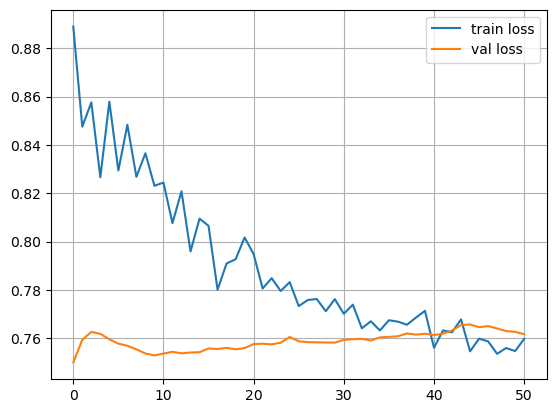

In [101]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=256,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize), label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize), label="val loss")
plt.legend()
plt.grid()
plt.show() 

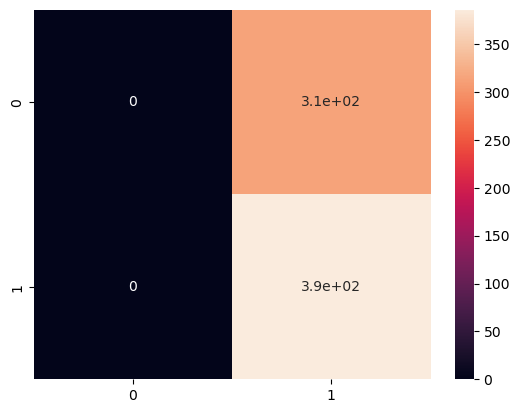

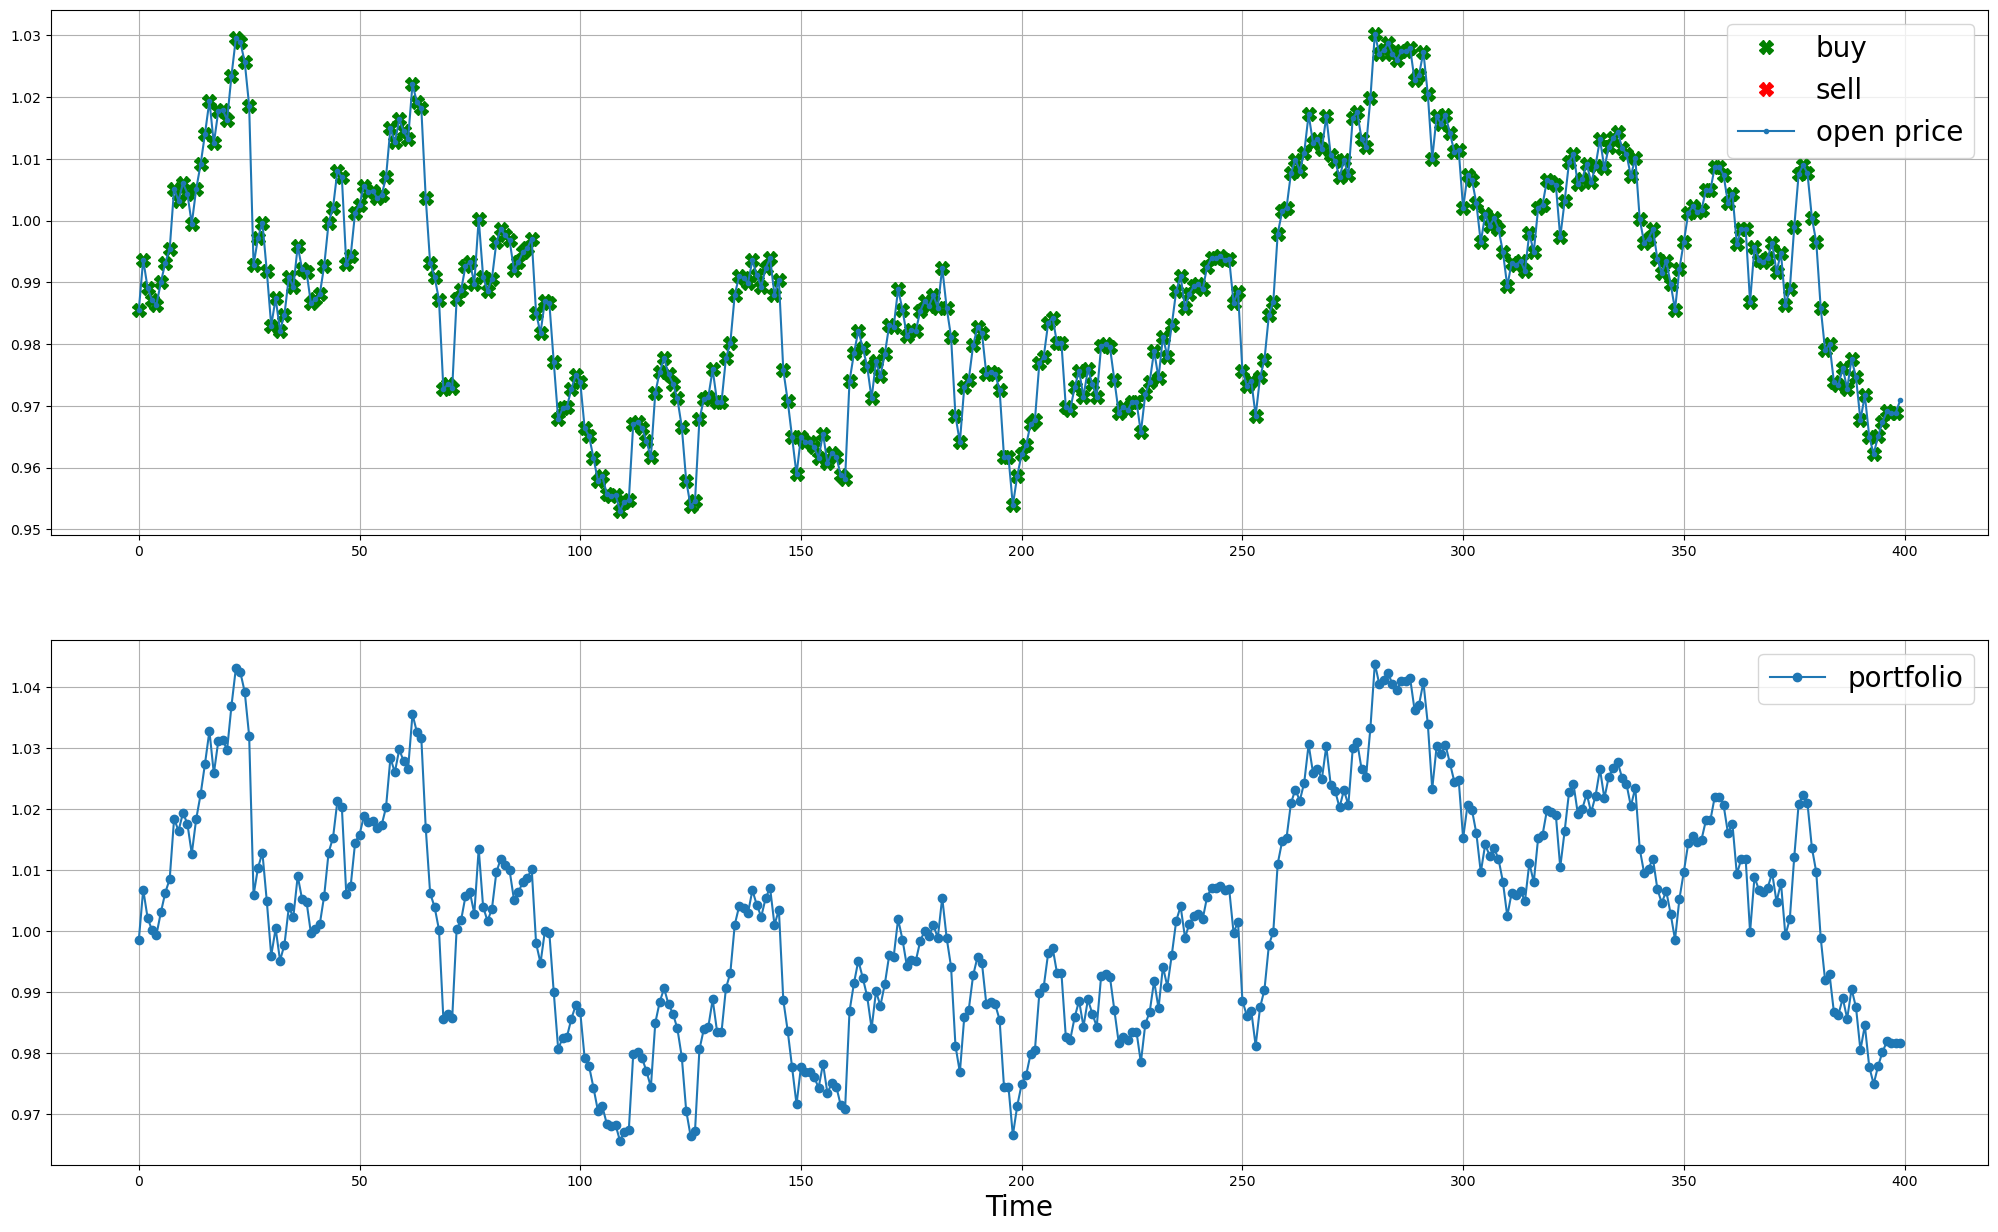

ACC           0.551429
MEAN RET %   -0.002962
Name: GRU_AE, dtype: float64

In [102]:
outputs_GRU_AE_Trend, targets, ACC_GRU_AE_Trend = pl.evaluate_trend(model_GRU_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_AE_Trend = pl.evauate_strategy_trend(t, outputs_GRU_AE_Trend, plot=True, tax=1)

result_trend_df['GRU_AE'] = [ACC_GRU_AE_Trend, MEAN_RET_GRU_AE_Trend]
result_trend_df['GRU_AE']

## Result 

### Price

In [103]:
result_price_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE  \
MSE         0.000151  0.000099  0.000084  0.000184  0.000271  0.000157   
ACC         0.529328  0.502146  0.525036  0.494993  0.446352  0.520744   
MEAN RET % -0.081597  0.048840 -0.020455  0.001098 -0.002962  0.021576   

            Dense_AE_REG  LSTM_AE_REG  GRU_AE_REG  
MSE             0.000141     0.000155    0.000175  
ACC             0.519313     0.517883    0.522175  
MEAN RET %      0.014369     0.022416    0.010431

### Trend 

In [104]:
result_trend_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE
ACC         0.525714  0.501429  0.504286  0.444286  0.551429  0.551429
MEAN RET % -0.110008 -0.149459 -0.085370  0.000907 -0.002962 -0.002962